In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pandas as pd
import numpy as np
import re
from sklearn import svm
import matplotlib.pyplot as plt

In [2]:
scripts_path = os.path.abspath(os.path.join('../scripts'))
if scripts_path not in sys.path:
    sys.path.insert(0,scripts_path)

In [3]:
from station_location import *

In [4]:
TRAIN_SET = '../data/first-train.slist'
TEST_SET = '../data/first-test.slist'
TRUE_VALUES_SET = '../data/2018.csv'
ANTENNA_INDEX = 0
SPS_INDEX = 2
START_TIME_INDEX = 3
TIME_WINDOW = 59
WAIT_TIME_WINDOW = 1

In [5]:
# Assuming what is computed here is common to test and train
header = pd.read_csv(TRAIN_SET, sep='\t', nrows=0).columns[0].split(', ')

# Number of samples per second
sps = int(re.findall(r'\d+', header[SPS_INDEX])[0])
# Number of samples per windows
spw = (TIME_WINDOW + WAIT_TIME_WINDOW) * sps

# Antenna
antenna = header[ANTENNA_INDEX].split(' ')[1].split('_')
network = antenna[0]
station = antenna[1]
channel = antenna[3]

latitude, longitude, elevation = get_location(network, station, channel)

In [6]:
latitude, longitude, elevation

(35.79657, -97.454857, 333.0)

In [7]:
compute_distance(latitude, longitude, elevation, latitude, longitude, -5645)

5978.000000000265

In [8]:
compute_distance(latitude, longitude, elevation, 36.45094, -98.79978, -5645)

141239.64380985397

In [9]:
def load_data(filename):
    header = pd.read_csv(filename, sep='\t', nrows=0).columns[0].split(', ')
    start_time = pd.to_datetime(header[START_TIME_INDEX])
    
    X = pd.read_csv(filename, sep='\t', header=0, names=["1", "2", "3", "4", "5", "6"])
    X = X.to_numpy().reshape(-1)
    X = X[~(np.isnan(X))]
    
    return X, start_time

In [11]:
catalog = pd.read_csv(TRUE_VALUES_SET)
catalog["origintime"] = pd.to_datetime(catalog["origintime"])
catalog.sort_values("origintime", inplace=True)
catalog

event_id          origintime  magnitude magnitude_source max_mmi  \
0            0 2018-01-01 01:43:55        2.0              OGS       0   
1            0 2018-01-01 03:39:47        1.9              OGS       0   
2            0 2018-01-01 04:06:26        1.9              OGS       0   
3            0 2018-01-01 05:29:18        2.0              OGS       0   
4            0 2018-01-01 05:46:00        2.3              OGS       0   
...        ...                 ...        ...              ...     ...   
2677      4412 2018-12-30 19:42:21        2.1              OGS    None   
2678      4060 2018-12-30 23:51:51        2.0              OGS    None   
2679      4169 2018-12-31 07:22:29        2.6              OGS    None   
2680      4096 2018-12-31 09:30:56        2.7              OGS    None   
2681      4229 2018-12-31 22:35:03        2.3              OGS    None   

       latitude  longitude  depth_km  err_lat  err_lon  err_depth  \
0     36.880480 -97.927090     5.953     0.30     0.40       0.70   
1     36.880650 -97.931490     5.602     0.70     0.70       1.60   
2     36.845090 -97.703160     7.647     0.60     0.60       1.40   
3     36.150520 -97.668760     5.000     0.30     0.40       0.80   
4     36.152550 -97.658960     5.345     0.30     0.30       0.80   
...         ...        ...       ...      ...      ...        ...   
2677  36.263050 -97.184258     3.510     4.58     2.00       2.49   
2678  36.230167 -97.939167     2.940     0.35     0.35       1.40   
2679  35.941667 -96.728667     6.040     0.21     0.21       0.40   
2680  35.674000 -97.390000     5.860     0.14     0.14       0.40   
2681  35.941667 -96.729833     6.180     0.21     0.21       0.40   

     err_origintime     state    county    status  
0              0.34      None     GRANT      None  
1              0.38      None     GRANT      None  
2              0.44      None     GRANT      None  
3              0.35      None     LOGAN      None  
4              0.39      None     LOGAN      None  
...             ...       ...       ...       ...  
2677      0.7722337  Oklahoma     Noble  Reviewed  
2678           None  Oklahoma  Garfield  Reviewed  
2679           None  Oklahoma     Payne  Reviewed  
2680           None  Oklahoma  Oklahoma  Reviewed  
2681           None  Oklahoma     Payne  Reviewed  

[2682 rows x 15 columns]

In [12]:
# 2018-04-09 10:22:20
dist_1 = 49470.577600 
time_1 = 9.039
speed_1 = dist_1/time_1

# 2018-04-12 23:56:07
dist_2 = 117930.839431
time_2 = 20.283
speed_2 = dist_2/time_2

# 2018-04-11 23:37:03
dist_3 = 33191.937156
time_3 = 5.78
speed_3 = dist_3/time_3

speed_average = (speed_1 + speed_2 + speed_3)/3

#http://eqseis.geosc.psu.edu/cammon/HTML/Classes/IntroQuakes/Notes/waves_and_interior.html
print(f"Speed 1: {speed_1}m/s")
print(f"Speed 2: {speed_2}m/s")
print(f"Speed 3: {speed_3}m/s")
print(f"Average speed: {speed_average}m/s, which is in the same order of magnitude as said here: http://eqseis.geosc.psu.edu/cammon/HTML/Classes/IntroQuakes/Notes/waves_and_interior.html")

Speed 1: 5473.0144485009405m/s
Speed 2: 5814.270050337721m/s
Speed 3: 5742.5496809688575m/s
Average speed: 5676.611393269173m/s, which is in the same order of magnitude as said here: http://eqseis.geosc.psu.edu/cammon/HTML/Classes/IntroQuakes/Notes/waves_and_interior.html


In [13]:
def change_time_according_to_station(catalog, lat_station, lon_station, alt_station, speed_average):
    catalog["distance"] = catalog.loc[:, ["latitude", "longitude", "depth_km"]].apply(lambda row: compute_distance(lat_station, lon_station, alt_station, row[0], row[1], -1000*row[2]), axis=1)
    catalog["time_diff"] = catalog["distance"].map(lambda dist: dist/speed_average)
    catalog["origintime"] = catalog.loc[:, ["origintime", "time_diff"]].apply(lambda row: row[0] + pd.to_timedelta(row[1], unit='s'), axis=1)

In [14]:
change_time_according_to_station(catalog, latitude, longitude, elevation, speed_average)
catalog

event_id                    origintime  magnitude magnitude_source  \
0            0 2018-01-01 01:44:17.482678435        2.0              OGS   
1            0 2018-01-01 03:40:09.506652244        1.9              OGS   
2            0 2018-01-01 04:06:46.904160473        1.9              OGS   
3            0 2018-01-01 05:29:25.762432233        2.0              OGS   
4            0 2018-01-01 05:46:07.738645234        2.3              OGS   
...        ...                           ...        ...              ...   
2677      4412 2018-12-30 19:42:31.099859855        2.1              OGS   
2678      4060 2018-12-30 23:52:02.457021870        2.0              OGS   
2679      4169 2018-12-31 07:22:40.943855342        2.6              OGS   
2680      4096 2018-12-31 09:30:58.827032528        2.7              OGS   
2681      4229 2018-12-31 22:35:14.928135853        2.3              OGS   

     max_mmi   latitude  longitude  depth_km  err_lat  err_lon  err_depth  \
0          0  36.880480 -97.927090     5.953     0.30     0.40       0.70   
1          0  36.880650 -97.931490     5.602     0.70     0.70       1.60   
2          0  36.845090 -97.703160     7.647     0.60     0.60       1.40   
3          0  36.150520 -97.668760     5.000     0.30     0.40       0.80   
4          0  36.152550 -97.658960     5.345     0.30     0.30       0.80   
...      ...        ...        ...       ...      ...      ...        ...   
2677    None  36.263050 -97.184258     3.510     4.58     2.00       2.49   
2678    None  36.230167 -97.939167     2.940     0.35     0.35       1.40   
2679    None  35.941667 -96.728667     6.040     0.21     0.21       0.40   
2680    None  35.674000 -97.390000     5.860     0.14     0.14       0.40   
2681    None  35.941667 -96.729833     6.180     0.21     0.21       0.40   

     err_origintime     state    county    status       distance  time_diff  
0              0.34      None     GRANT      None  127625.428558  22.482678  
1              0.38      None     GRANT      None  127761.518551  22.506652  
2              0.44      None     GRANT      None  118664.795510  20.904160  
3              0.35      None     LOGAN      None   44064.311252   7.762432  
4              0.39      None     LOGAN      None   43929.281701   7.738645  
...             ...       ...       ...       ...            ...        ...  
2677      0.7722337  Oklahoma     Noble  Reviewed   57332.979523  10.099860  
2678           None  Oklahoma  Garfield  Reviewed   65037.060879  11.457022  
2679           None  Oklahoma     Payne  Reviewed   67800.625312  11.943855  
2680           None  Oklahoma  Oklahoma  Reviewed   16047.965057   2.827033  
2681           None  Oklahoma     Payne  Reviewed   67711.391881  11.928136  

[2682 rows x 17 columns]

In [15]:
def count_signs_per_row(X, amplitude):
    print(X.shape)
    X = X - np.mean(X, axis=1).reshape(X.shape[0], 1)
    first_kernel = X[:,1:]
    second_kernel = X[:,:-1]
    change_of_sign = first_kernel * second_kernel
    
    return np.sum(change_of_sign < -amplitude, axis=1).reshape(X.shape[0], 1)

In [16]:
def weighted_sliding_mean_per_row(X, mean_size):
    N, W = X.shape
    diff = np.abs(X[:, 1:] - X[:, :-1])
    diff = diff[:, mean_size-1:]
    
    diff_sliding_mean = np.zeros((N, W - (mean_size - 1)))
    for i, w in enumerate(X):
        diff_sliding_mean[i] = np.abs(np.convolve(w, np.ones(mean_size), 'valid') / mean_size)
    weighted_diff = diff / (diff_sliding_mean[:,:-1] + 1)
    
    return np.max(weighted_diff, axis=1).reshape((N, 1))

In [17]:
def fourier_features(X, min_freq):
    # Number of samplepoints
    N = X.shape[0]

    # sample spacing
    T = 1.0 / 400
    
    X = X - np.mean(X, axis=1).reshape((N, 1))
    xf = np.fft.fft(X, axis=1)
    x_amplitudes = 2.0/N * np.abs(xf[:, :N//2])
    medians = np.median(x_amplitudes, axis=1).reshape(N, 1)
    means = np.mean(x_amplitudes[:, min_freq:], axis=1).reshape(N, 1)
    
    return np.hstack((medians, means))

In [24]:
def compute_end_time(X, start_time):
    total_number_of_seconds = (X.shape[0] - 1) / sps # First sample is at starting time -> subtract 1
    end_time = start_time + pd.to_timedelta(total_number_of_seconds, unit='s')

    return end_time
#total_number_of_seconds = (X_test_raw.shape[0] - 1) / sps # First sample is at starting time -> subtract 1
#endTime_test = startTime_test + pd.to_timedelta(total_number_of_seconds, unit='s')
#print(f"Data from {startTime_test.date()} to {endTime_test.date()}") 

def compute_X_and_y(filename, sps, catalog, amplitude):
    X, start_time = load_data(filename)
    end_time  = compute_end_time(X, start_time)
    
    catalog = catalog[(catalog["origintime"] >= start_time) & (catalog["origintime"] <= end_time)]
    
    
    N = X.shape[0]
    window_size = TIME_WINDOW*sps
    drop_size = WAIT_TIME_WINDOW*sps
    total_window_size = window_size + drop_size    
    number_window = np.math.floor(N / total_window_size)
    X = X[:number_window*total_window_size]
    X_time_window = np.array(np.split(X.reshape(-1), number_window))
    
    y = np.zeros((X_time_window.shape[0], 1))
    
    for date in catalog["origintime"]:
        seconds_to_hq = (date - start_time).total_seconds()
        index_in_data = seconds_to_hq * sps
        index = int(index_in_data / X_time_window.shape[1])
        y[index] = 1
    
    X_time_window = X_time_window[:, drop_size:]
    
    feature1 = count_signs_per_row(X_time_window, amplitude)
    feature2 = weighted_sliding_mean_per_row(X_time_window, 2)
    feature3_4 = fourier_features(X_time_window, 30)
    print(feature1.shape, feature2.shape, feature3_4.shape)
    
    time_stamps = pd.Series([start_time + pd.to_timedelta(i * (total_window_size / sps), unit='s') for i in range(X_time_window.shape[0])])
    
    return np.hstack((np.hstack((feature1, feature2)), feature3_4)), y, time_stamps

In [25]:
X_train, y_train, time_stamps = compute_X_and_y(TRAIN_SET, sps, catalog, 100000)
X_train.shape, y_train.shape

(5760, 5900)
(5760, 1) (5760, 1) (5760, 2)


((5760, 4), (5760, 1))

In [26]:
X_test, y_test, time_stamps_test = compute_X_and_y(TEST_SET, sps, catalog, 100000)

(1440, 5900)
(1440, 1) (1440, 1) (1440, 2)


## Training

In [44]:
clf = svm.SVC(gamma='scale', class_weight={-1: 1, 1: 50})
y_train[y_train==0] = -1
clf.fit(X_train, y_train.ravel())

SVC(C=1.0, cache_size=200, class_weight={-1: 1, 1: 50}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [45]:
from sklearn.metrics import confusion_matrix
y_test[y_test==0] = -1
confusion_matrix(y_train, clf.predict(X_train))

array([[5610,  120],
       [  20,   10]])

In [34]:
confusion_matrix([-1, -1, -1, 1, -1, 1], [-1, -1, -1, -1, -1, -1])

array([[4, 0],
       [2, 0]])

## Little manual checks

In [130]:
earthquake_time_stamps = time_stamps[f_y[:, 0] == 1]
not_earthquake_time_stamps = time_stamps[f_y[:, 0] == 0]

In [131]:
earthquake_indexes = f_y == 1
non_earthquake_indexes = f_y == 0

In [132]:
list(zip(f_y[f_y == 1], f_X[np.hstack((earthquake_indexes, earthquake_indexes))], earthquake_time_stamps))

IndexError: boolean index did not match indexed array along dimension 1; dimension is 4 but corresponding boolean dimension is 2

In [133]:
list(zip(f_y[f_y == 1], f_X[np.hstack((non_earthquake_indexes, non_earthquake_indexes))], earthquake_time_stamps))

IndexError: boolean index did not match indexed array along dimension 1; dimension is 4 but corresponding boolean dimension is 2

In [28]:
time_hq = pd.to_datetime("2018-04-09 10:22:18")
second_to_hq = (time_hq - startTime).total_seconds()

time_window_hq = X[int(second_to_hq * sps): int(second_to_hq * sps) + spw]
time_window_hq = time_window_hq - np.mean(time_window_hq)

In [29]:
# Not hearthquake
time_window = X[0:6000]
time_window = time_window - np.mean(time_window)

In [30]:
change_of_sign = time_window[1:] * time_window[:-1]
(change_of_sign < -100000).sum()

5

In [31]:
change_of_sign = time_window_hq[1:] * time_window_hq[:-1]
(change_of_sign < -100000).sum()

551

In [83]:
def get_window_timestamp(date):
    seconds_to_hq = (pd.to_datetime(date) - startTime).total_seconds()
    time_window = X[int(seconds_to_hq * sps): int(seconds_to_hq * sps) + spw]
    
    return time_window

def plot_window_time_and_fft(time_window, earthquake, stats, i):
    # Number of samplepoints
    N = 600

    # sample spacing
    T = 1.0 / 400

    x = np.arange(np.shape(time_window)[0])
    y = time_window - np.mean(time_window)

    xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
    yf = np.fft.fft(y)
    y_amplitudes = 2.0/N * np.abs(yf[:N//2])
    med = np.median(y_amplitudes)
    mean = np.mean(y_amplitudes[30:])
    jules = np.median(y_amplitudes[30:] * xf[30:])
    print(f"Median : {med} Mean: {mean} Jules: {jules}")
    stats.loc[i] = [med, mean, jules]

    _, axs = plt.subplots(ncols=2, figsize=(20,8))
    title = "Earthquake time window" if earthquake else "Not earthquake time window"
    plt.suptitle(title, fontsize=18)
    
    # Plot time
    axs[0].plot(x, y)
    axs[0].set_title("Time plot for time window", fontsize=18)
    axs[0].set_xlabel("Time", fontsize=13)
    axs[0].set_ylabel("Value", fontsize=13)
    
    # Plot frequency
    axs[1].plot(xf, 2.0/N * np.abs(yf[:N//2]))
    axs[1].set_title("FFT plot for time window", fontsize=18)
    axs[1].set_xlabel("Frequency", fontsize=13)
    axs[1].set_ylabel("Amplitude", fontsize=13)
    
    plt.show() 

def plot_window_timestamp(date, earthquake, stats, i):
    time_window = get_window_timestamp(date)
    plot_window_time_and_fft(time_window, earthquake, stats, i)

In [84]:
len(earthquake_time_stamps)

30

In [85]:
stats

median        mean         jules
0      65.409658   64.030278   5587.690072
1000   17.469041   22.605098   1484.257014
1      38.629920   40.444352   3085.680236
1001   14.204345   15.965232   1222.313001
2      11.261054   12.167593    886.122483
1002   46.331259   48.704196   3164.017169
3      89.476663  109.621367   8374.847123
1003   30.750608   31.845445   2216.799776
4      65.409658   64.030278   5587.690072
1004   68.653431   85.090753   6724.697606
5     489.049083  508.147692  39685.939194
1005   11.601497   13.553691   1000.642059
6      61.176962   63.330650   5723.639404
1006   17.051180   18.110683   1406.771278
7      67.799721   77.653741   5932.857195
1007   22.880859   24.407113   1743.235574
8      38.629920   40.444352   3085.680236
1008   11.072540   14.162253   1030.230440
9     161.642850  173.912415  17516.505181
1009   32.042958   38.859700   3078.342291
10    117.626251  124.298263  12023.889991
1010  101.065576  134.502500  11232.515376
11     11.328129   13.004135    933.231104
1011   23.420169   23.852147   1910.026763
12    104.839302  100.374191   8600.336131
1012   31.453751   33.109298   2600.299645
13    183.933131  186.585294  17562.433324
1013   10.057874   11.715671    860.136256
14     62.968259   62.485929   5613.139239
1014   20.020848   31.886386   1914.918760
15     82.438639   84.882684   7294.521277
1015   14.744234   16.952919   1098.348466
16    104.839302  100.374191   8600.336131
1016   25.887430   31.449847   2457.124721
17     51.989464   53.205270   3780.874029
1017   26.653375   27.396768   2358.725757
18     82.438639   84.882684   7294.521277
1018   10.969389   11.754935    983.999099
19    117.626251  124.298263  12023.889991
1019   72.783582   80.638493   6159.750680
20    489.049083  508.147692  39685.939194
1020   64.495721   82.138153   5394.143016
21     28.779895   28.518032   2152.837532
1021   25.124019   26.191169   2313.228330
22     82.033093   85.360958   7519.718983
1022   18.568502   19.961227   1549.934153
23    104.839302  100.374191   8600.336131
1023   23.271794   24.662425   2110.474444
24    489.049083  508.147692  39685.939194
1024   23.043445   24.592626   2034.004290

Median : 28.97596899392604 Mean: 30.26193968499566 Jules: 2615.6801826398823


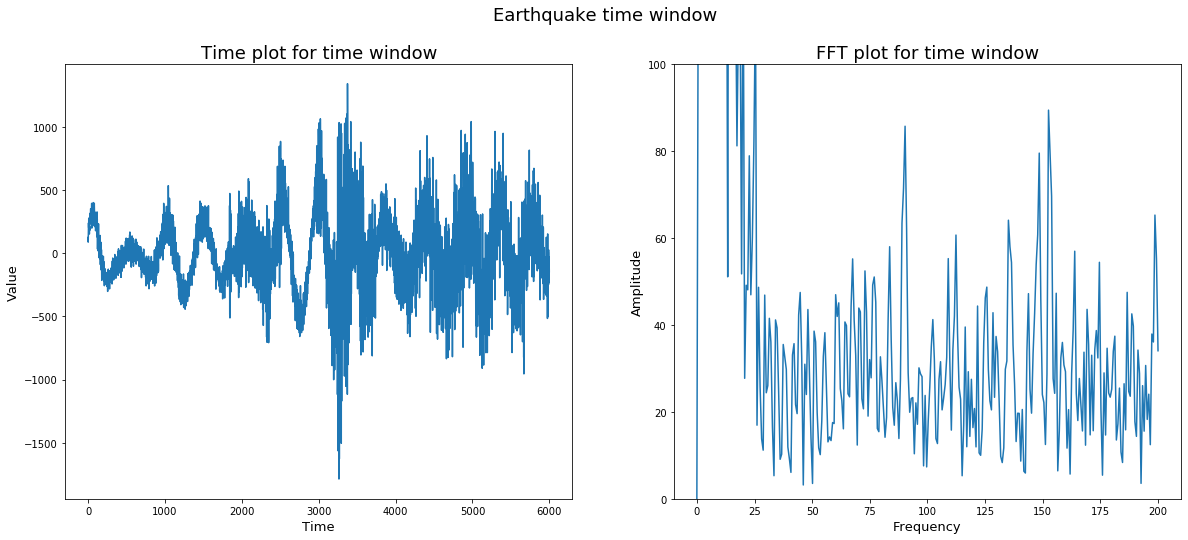

Median : 18.47101502435628 Mean: 19.17980482321854 Jules: 1697.0769274484194


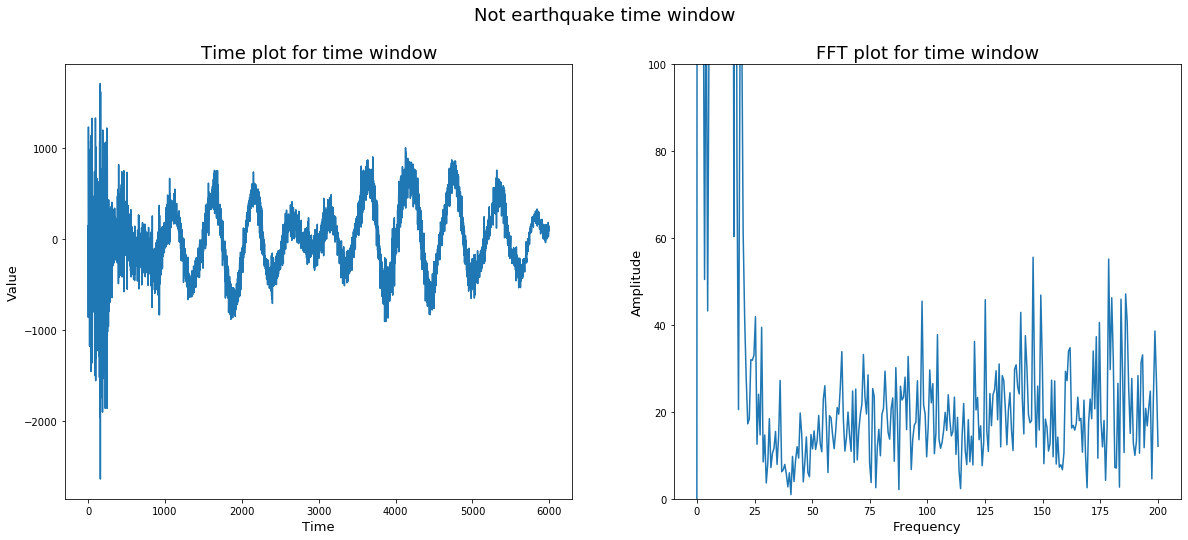

Median : 161.64284953886687 Mean: 173.9124148474195 Jules: 17516.505181180237


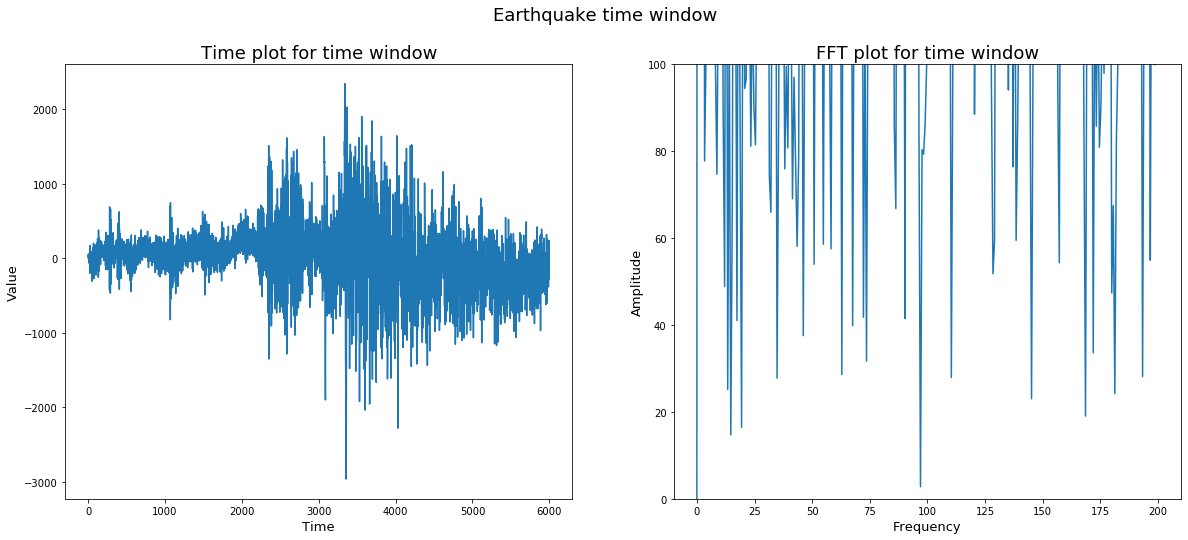

Median : 10.75352605061928 Mean: 12.243084463875093 Jules: 926.2584293307835


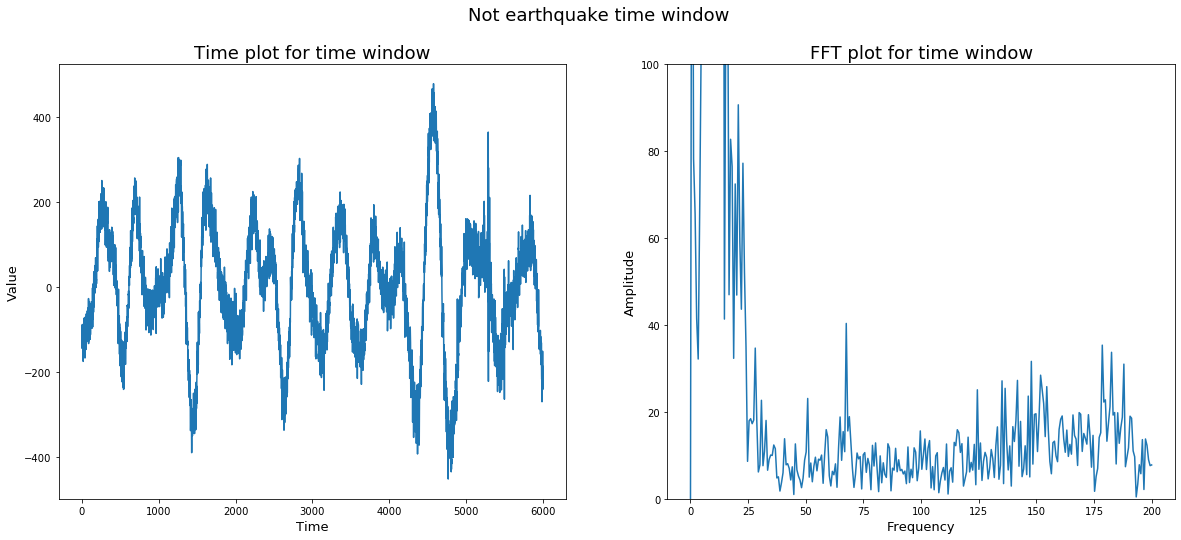

Median : 61.17696213047127 Mean: 63.33064972301557 Jules: 5723.639403914638


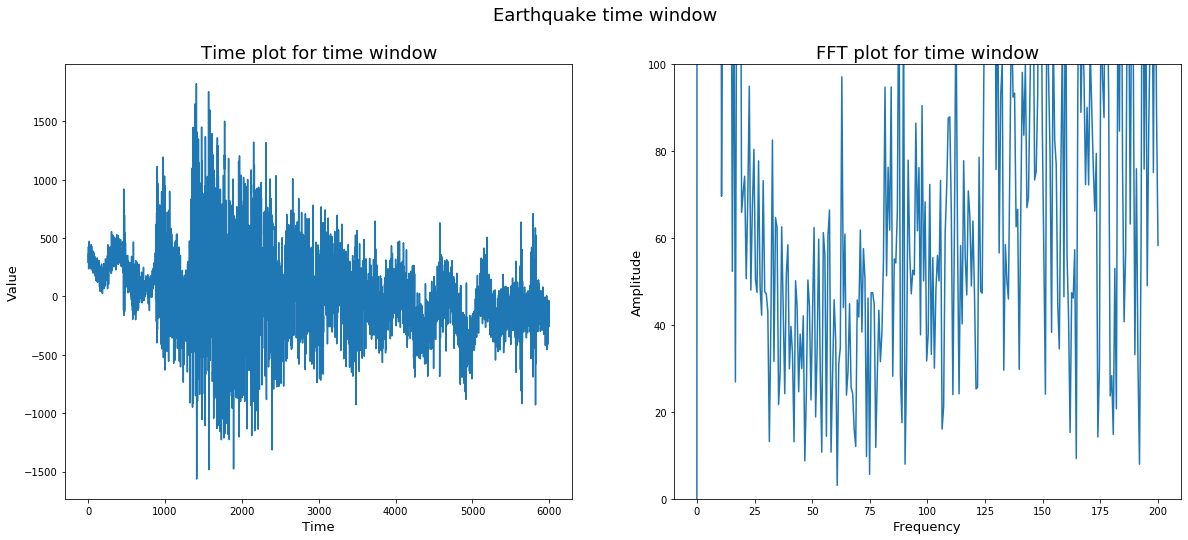

Median : 26.567091182010728 Mean: 27.54681180519281 Jules: 1970.6478574677371


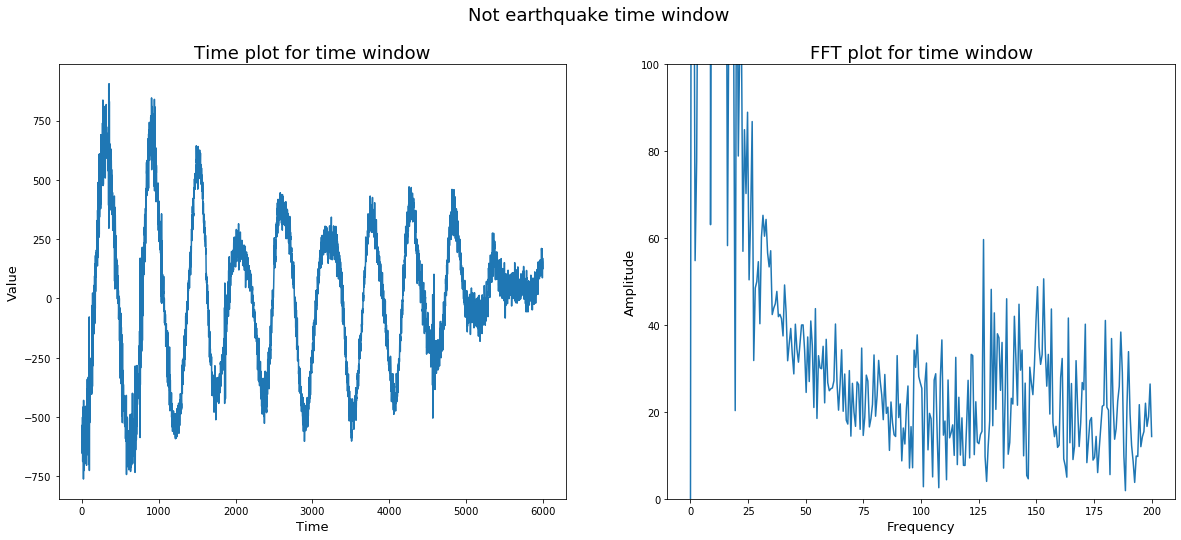

Median : 29.975640050909078 Mean: 30.73585463469795 Jules: 2974.7665740153197


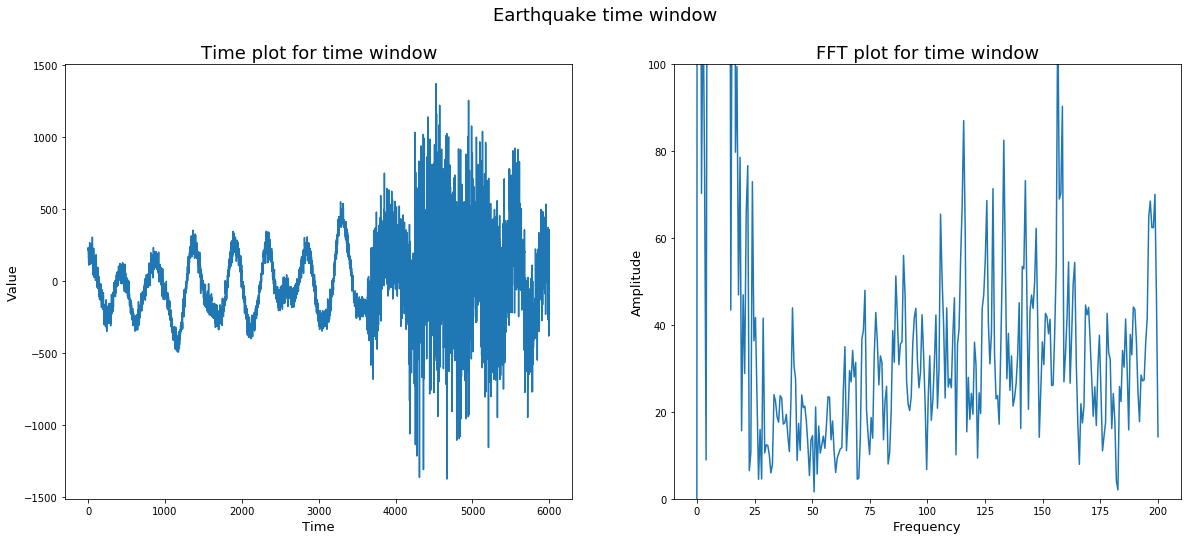

Median : 25.6998182844205 Mean: 29.645168022259394 Jules: 2033.3671578964659


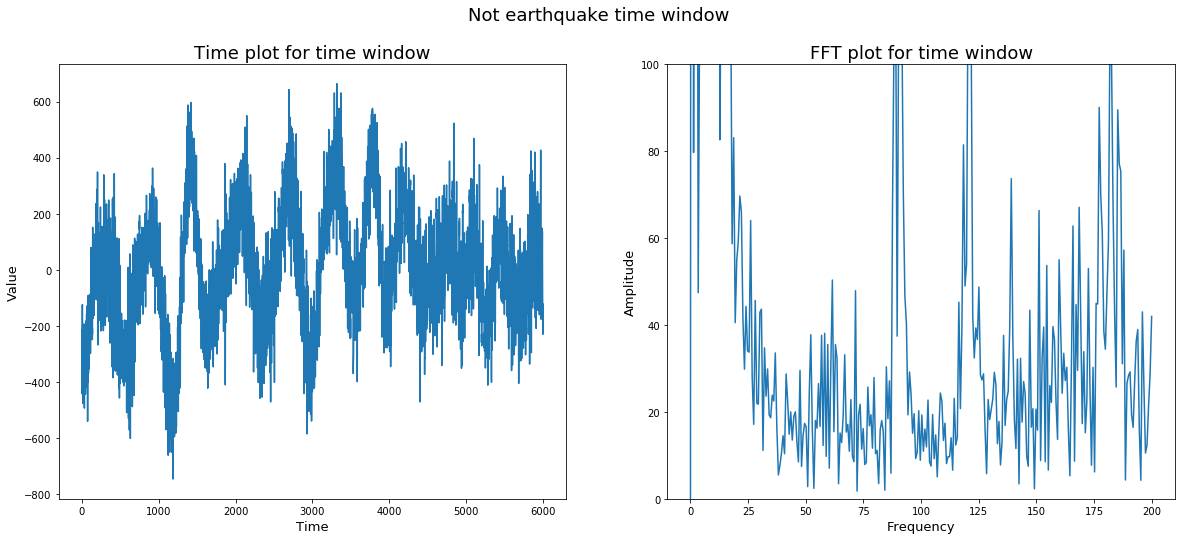

Median : 28.779894794145427 Mean: 28.518032101670318 Jules: 2152.8375318737317


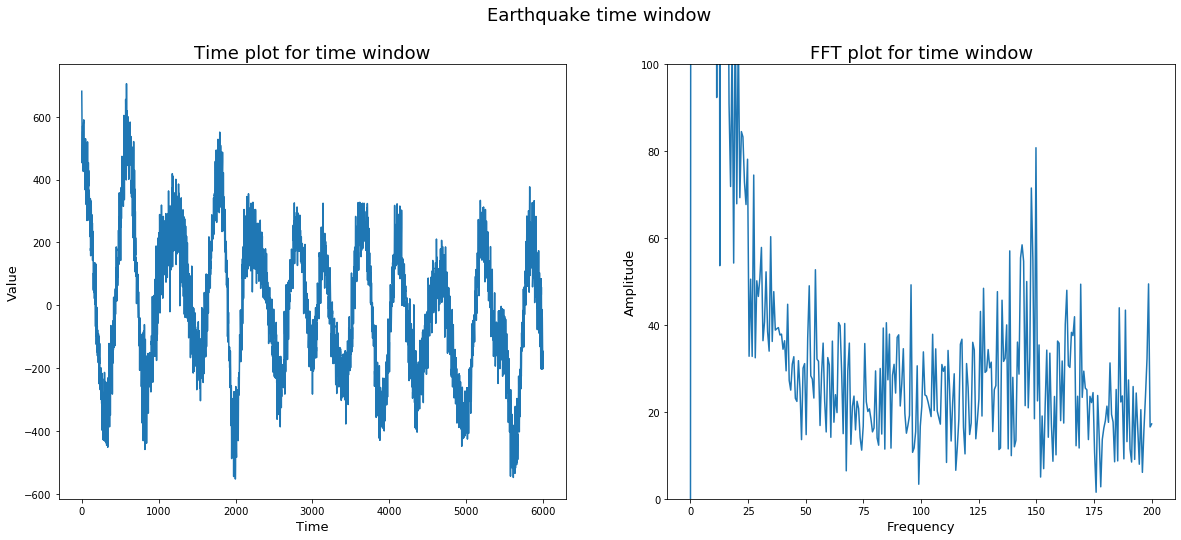

Median : 18.528394950202028 Mean: 20.839500504444732 Jules: 1747.5391280883714


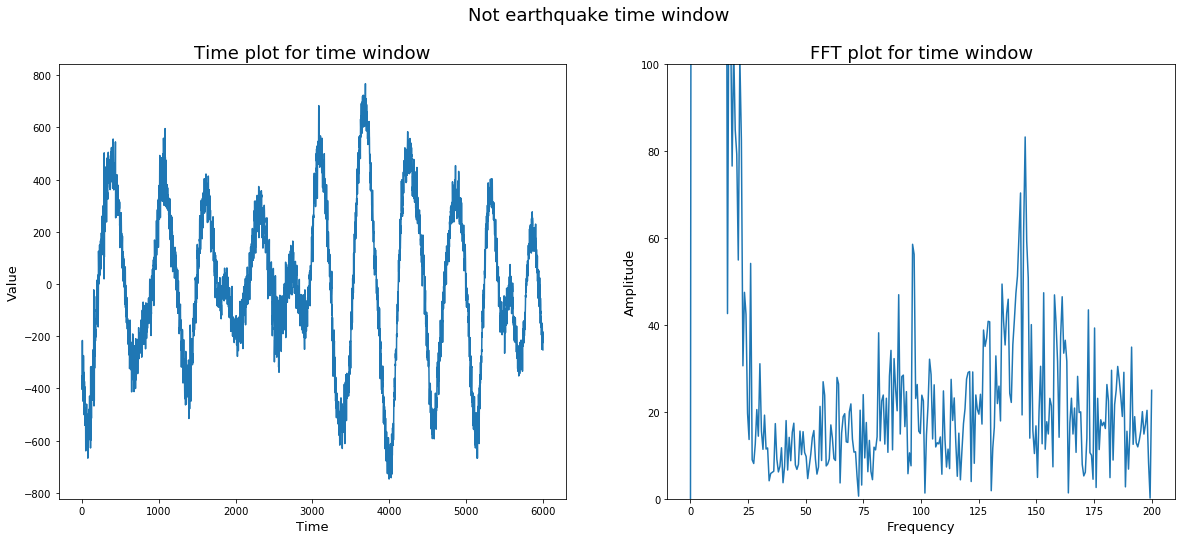

Median : 117.62625109982764 Mean: 124.29826340649042 Jules: 12023.889991078308


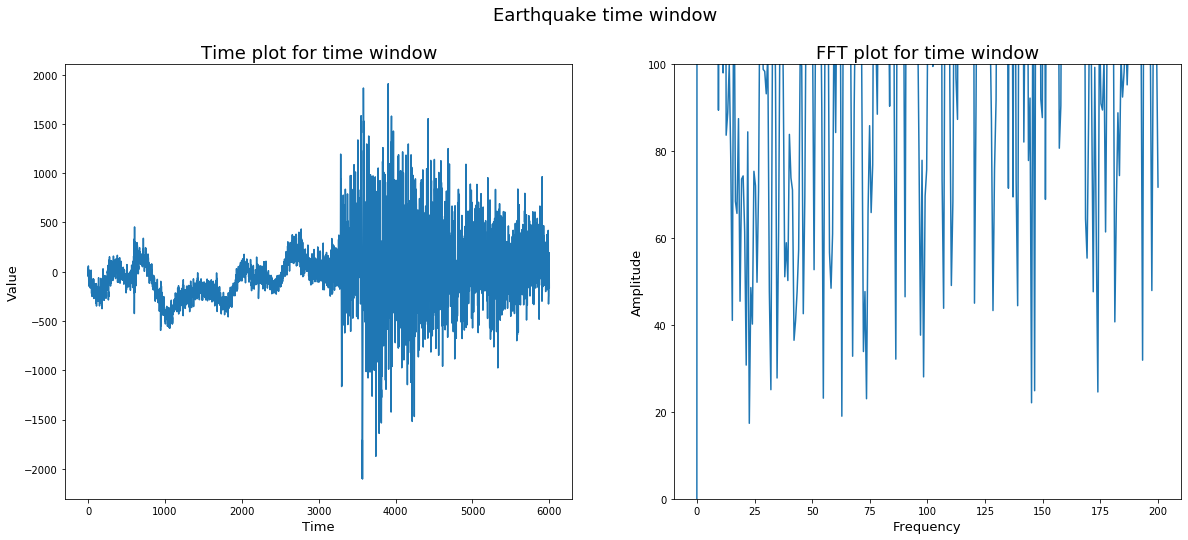

Median : 13.626784717271988 Mean: 14.078042898831718 Jules: 1134.1704727836218


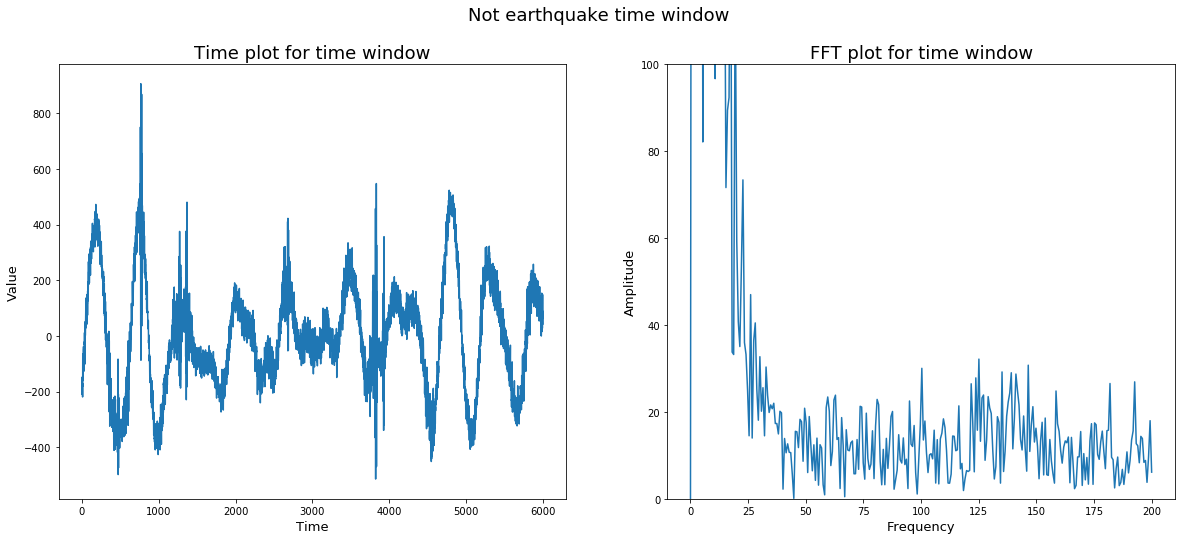

Median : 67.79972103510667 Mean: 77.65374065102631 Jules: 5932.857194798061


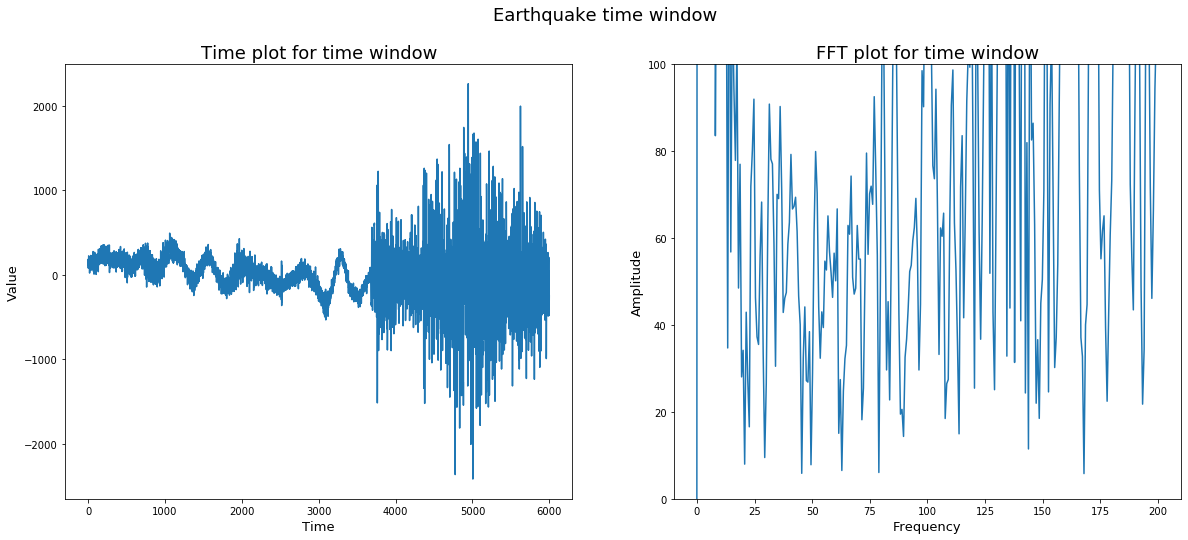

Median : 9.273942164243396 Mean: 9.909868036701408 Jules: 830.498869695022


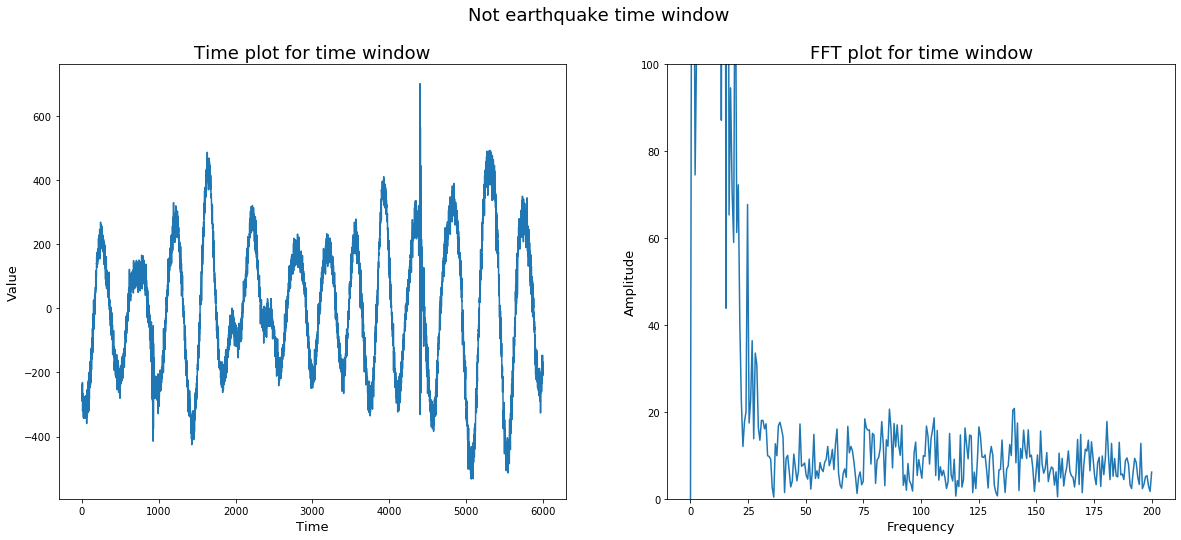

Median : 65.40965833161837 Mean: 64.03027793431966 Jules: 5587.690072160294


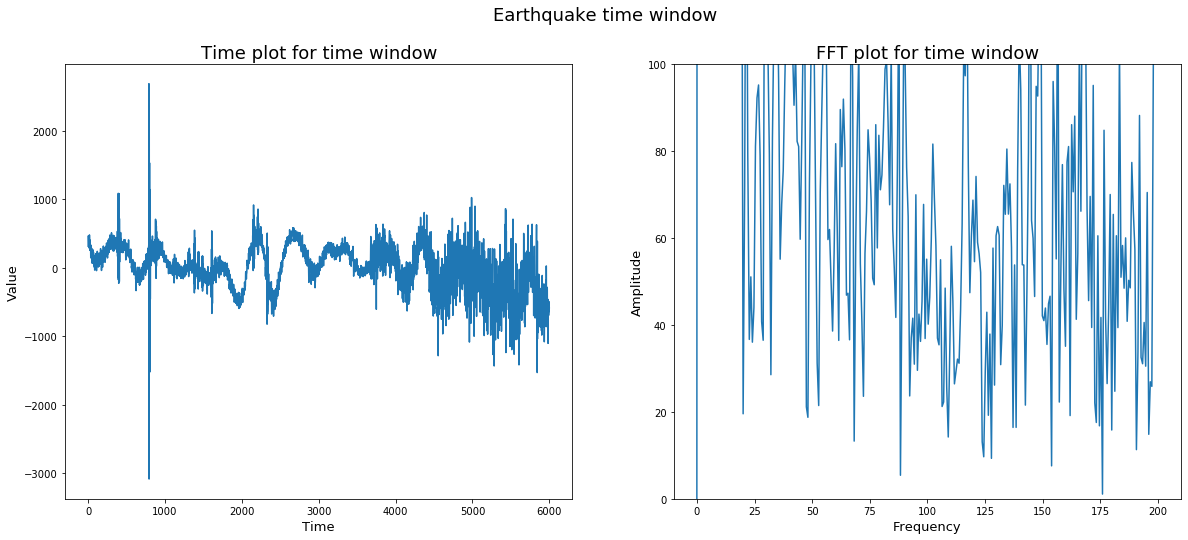

Median : 29.687229424415307 Mean: 33.29061578157861 Jules: 2992.5928007442526


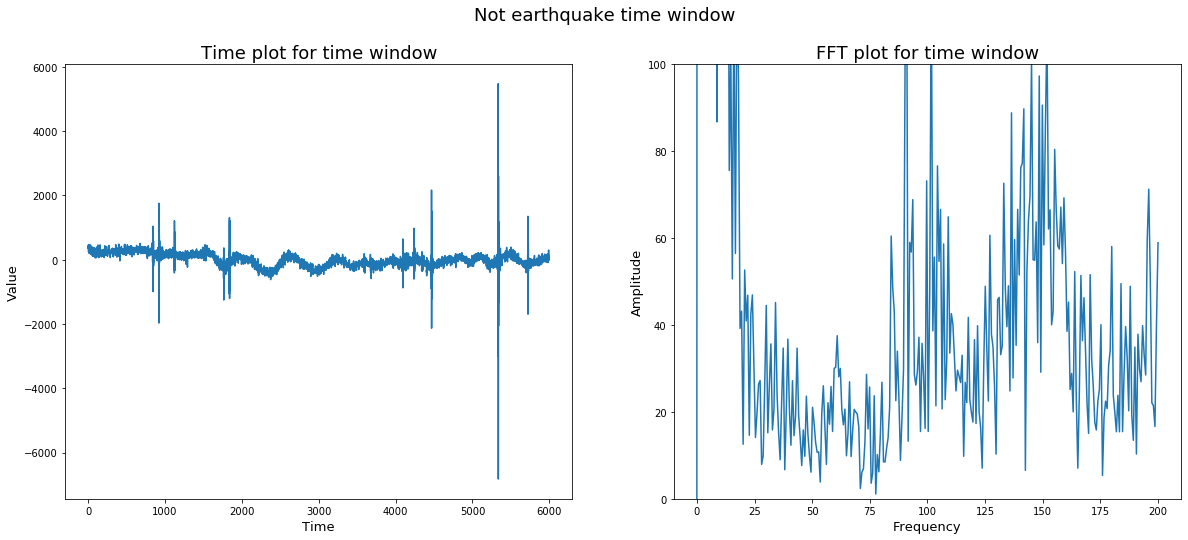

Median : 61.17696213047127 Mean: 63.33064972301557 Jules: 5723.639403914638


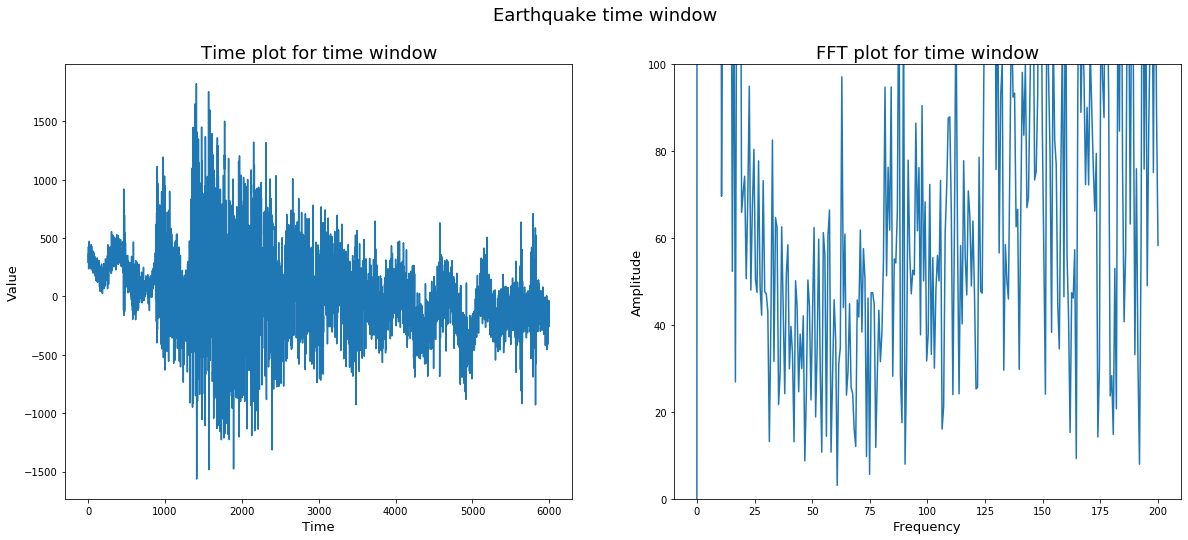

Median : 27.955550309929933 Mean: 27.897459299725433 Jules: 2239.925938365736


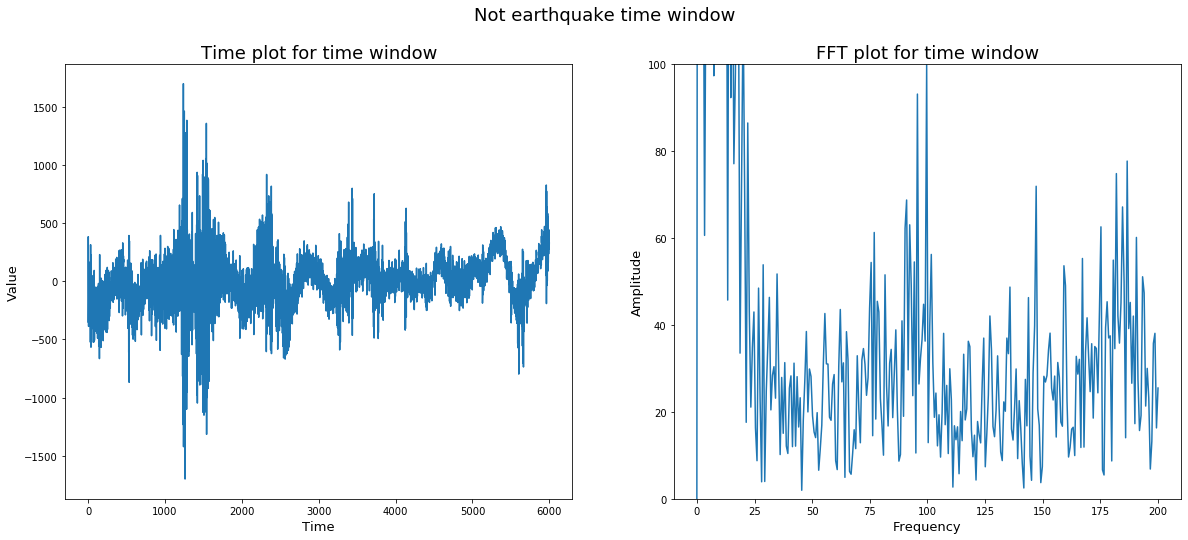

Median : 28.779894794145427 Mean: 28.518032101670318 Jules: 2152.8375318737317


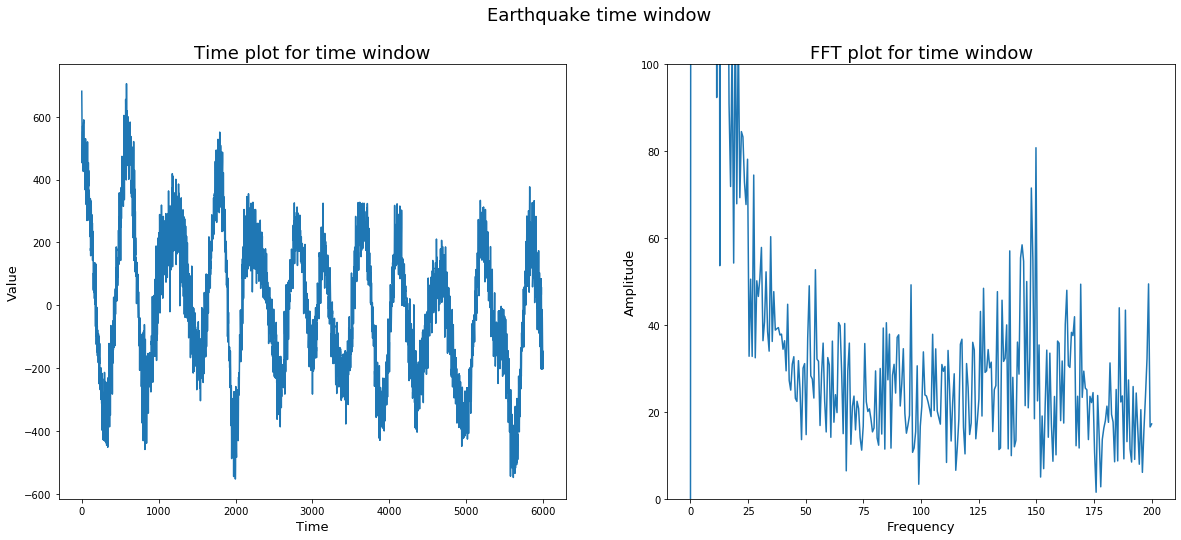

Median : 11.075543661296074 Mean: 12.470974773166102 Jules: 983.2186148650251


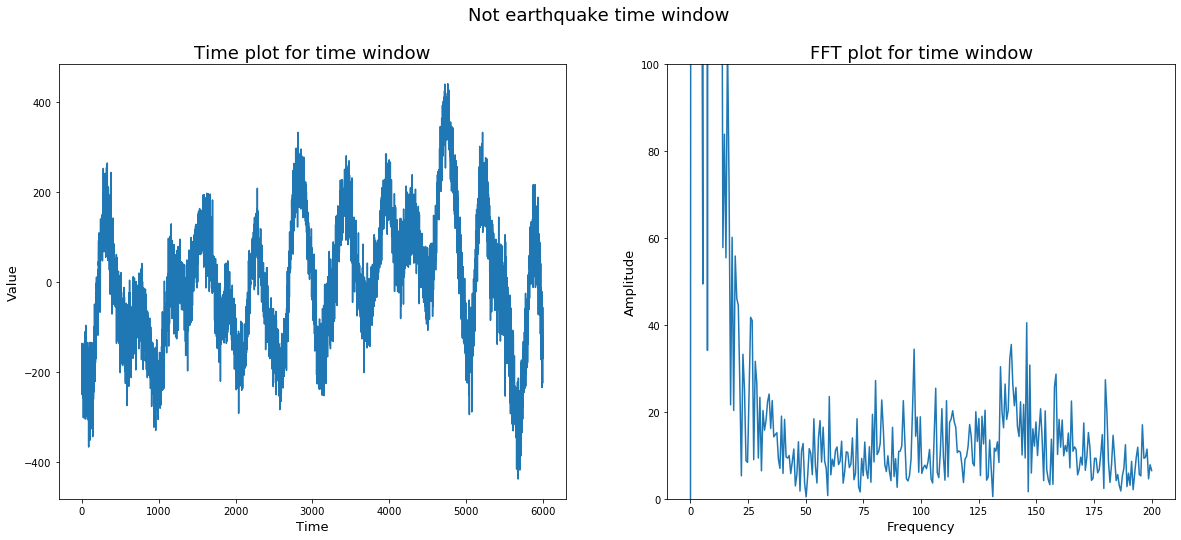

Median : 28.045551562436067 Mean: 27.05762917356522 Jules: 2518.1381895318646


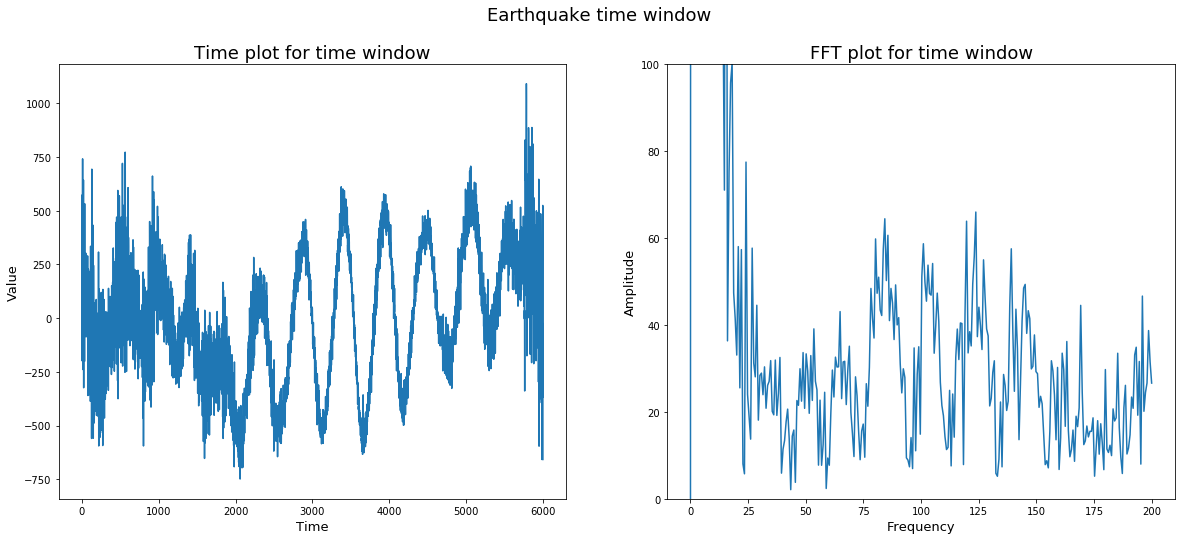

Median : 10.012525000957101 Mean: 13.111699200362674 Jules: 895.6084818900551


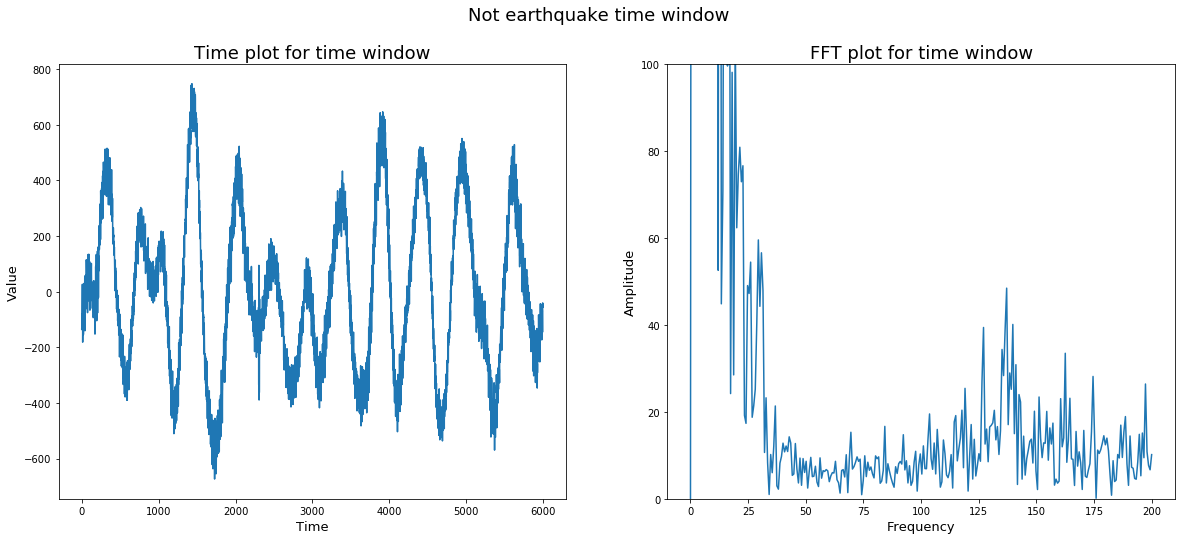

Median : 144.8398301537312 Mean: 143.60595009859014 Jules: 12349.528763976854


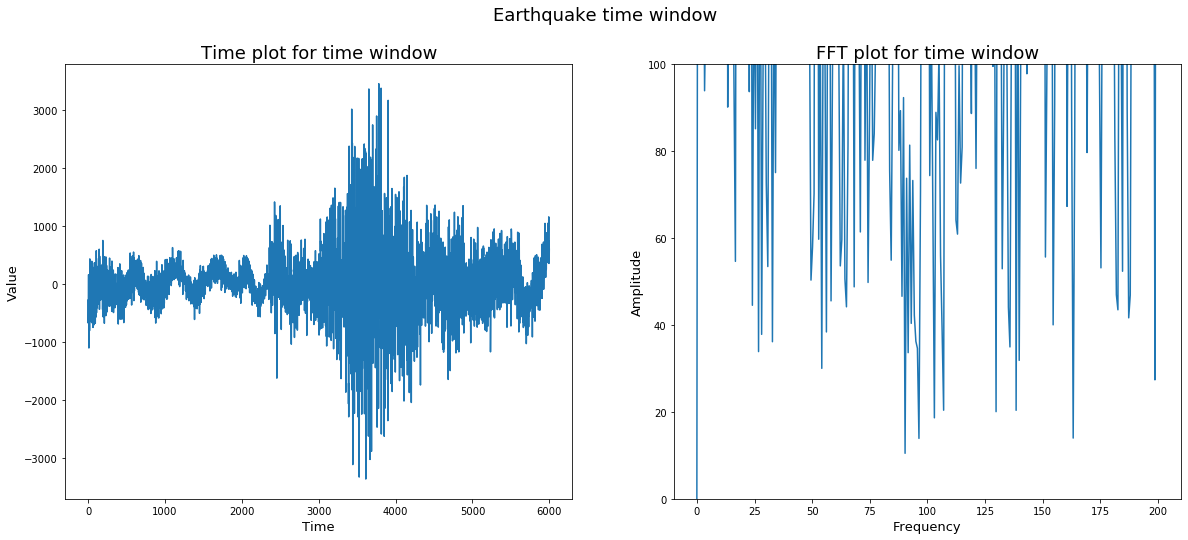

Median : 23.290791285636367 Mean: 25.602582097042582 Jules: 2147.7994836616153


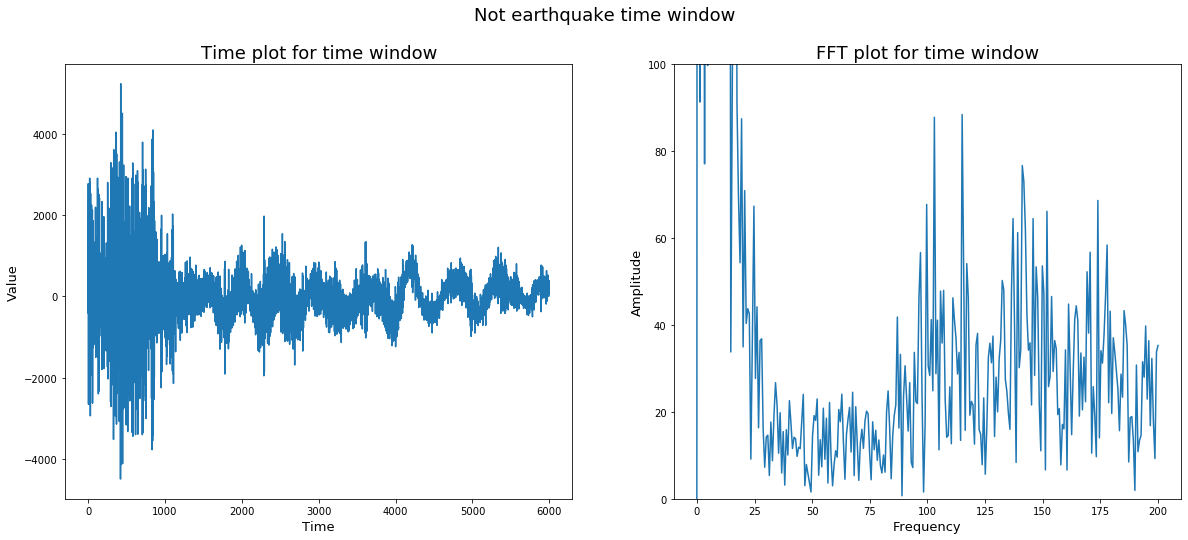

Median : 51.989464211643565 Mean: 53.205269683259985 Jules: 3780.8740294187023


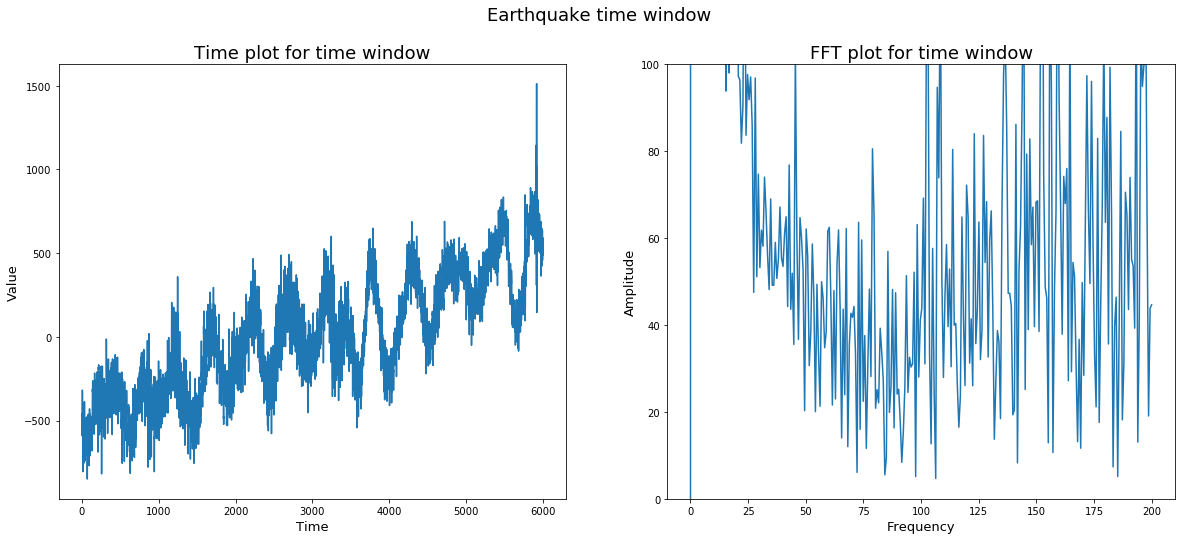

Median : 20.94245231858058 Mean: 26.358940175549904 Jules: 1709.8566663670097


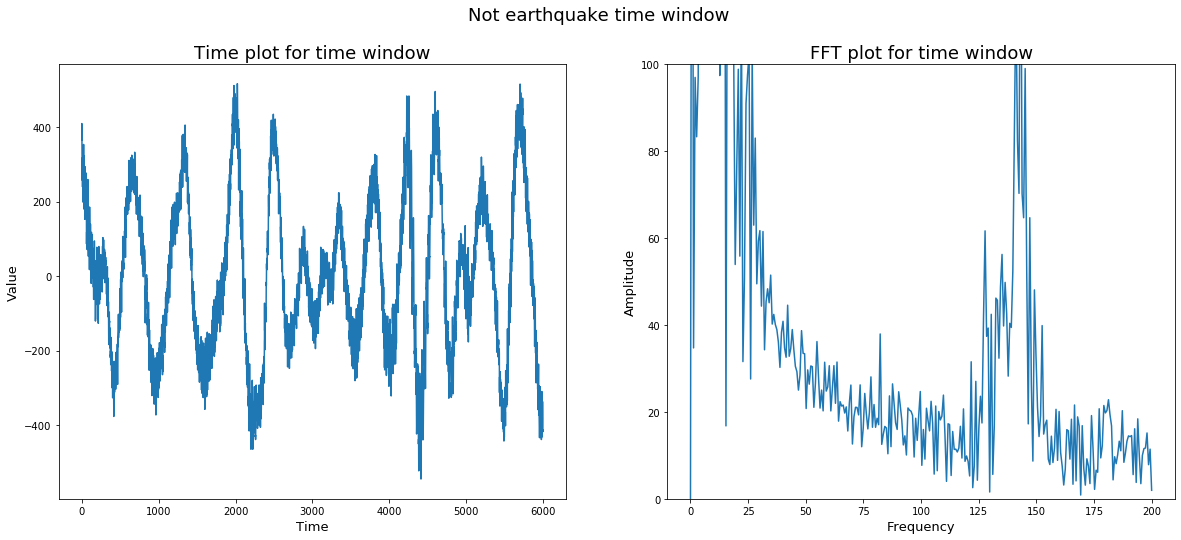

Median : 38.629920241385555 Mean: 40.44435216587564 Jules: 3085.680235719316


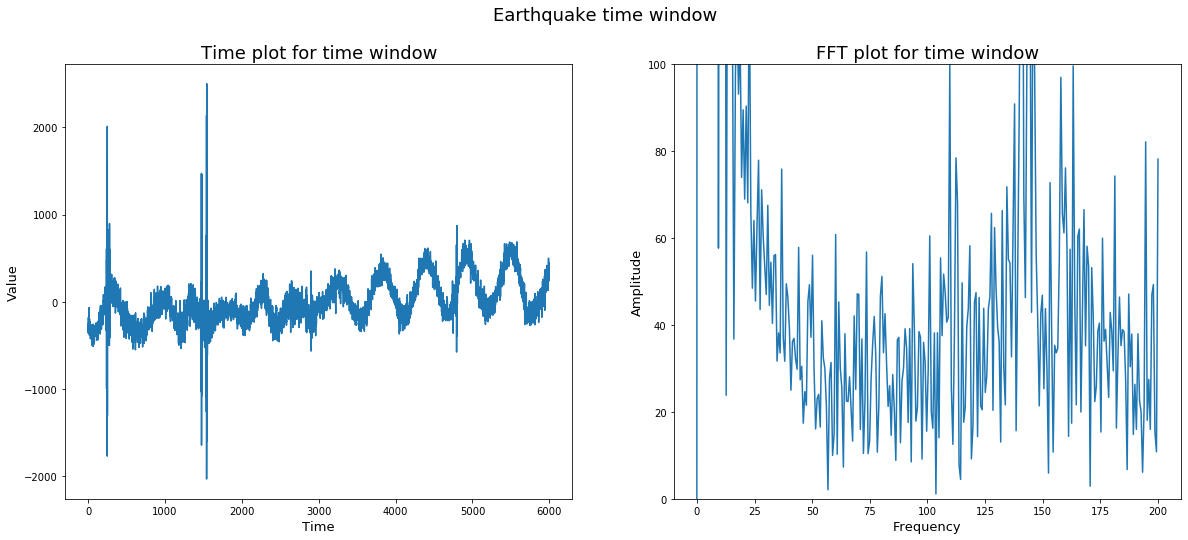

Median : 31.642603378199098 Mean: 31.07162283510382 Jules: 2467.0639482366


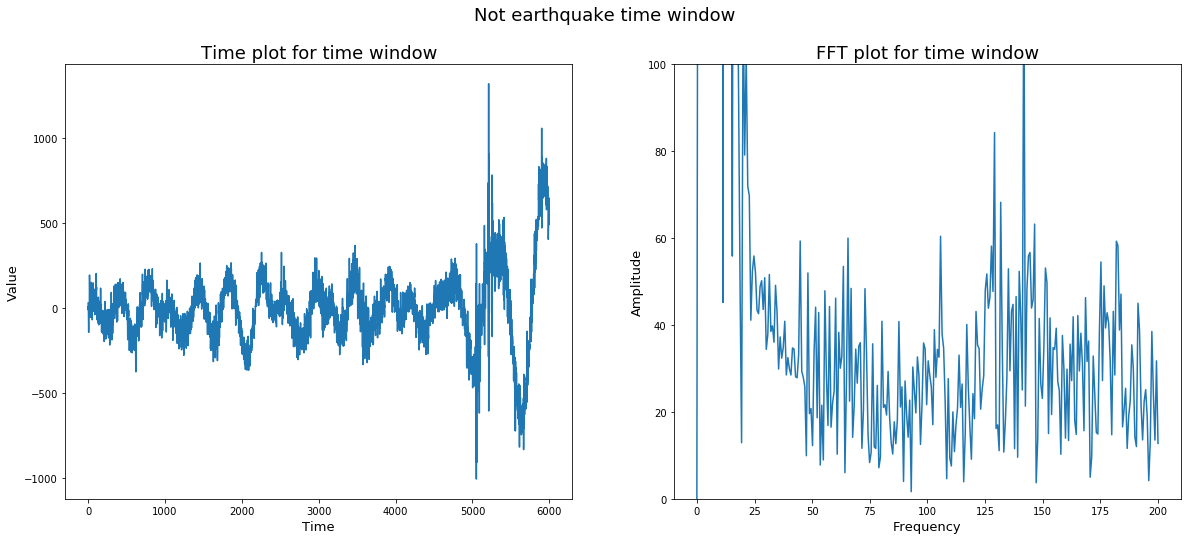

Median : 82.03309269513548 Mean: 85.36095848920931 Jules: 7519.718983336595


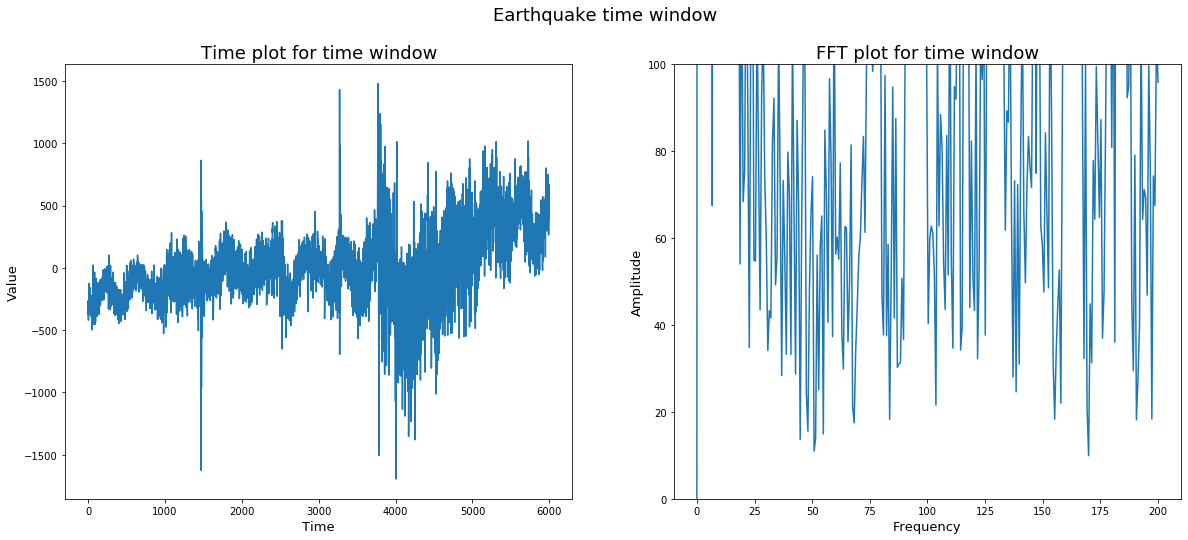

Median : 30.0087005971873 Mean: 31.193917678495268 Jules: 2267.075283832414


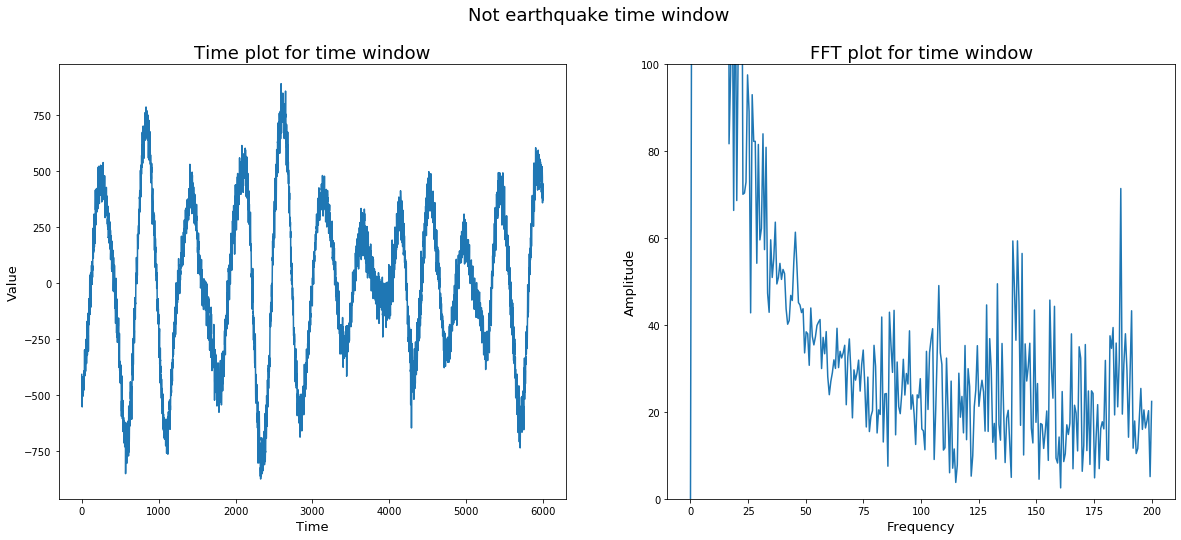

Median : 28.97596899392604 Mean: 30.26193968499566 Jules: 2615.6801826398823


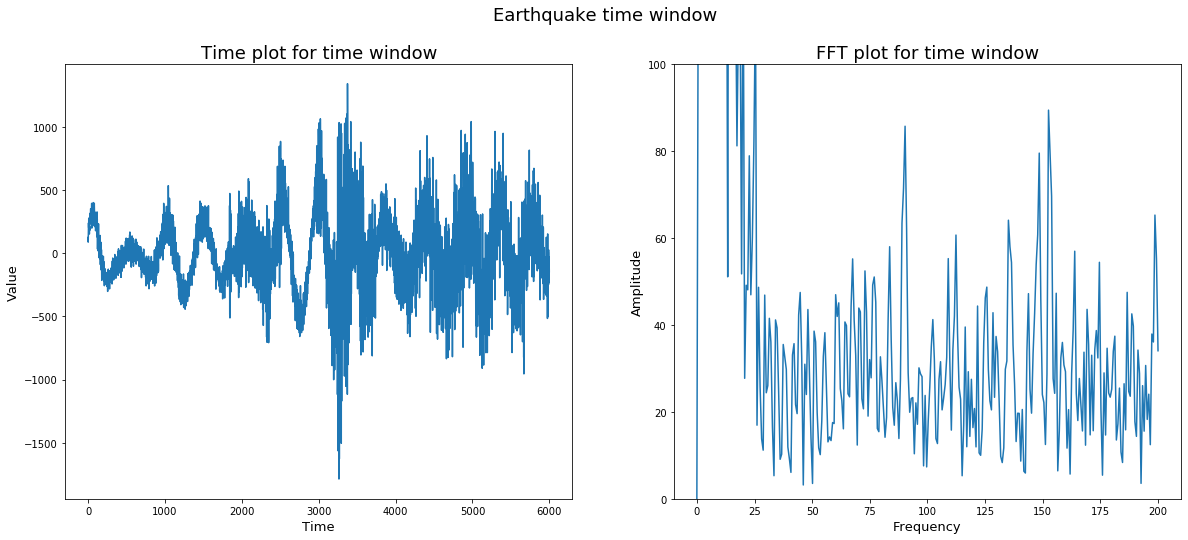

Median : 25.769045816818398 Mean: 25.115566495516703 Jules: 2056.789284341232


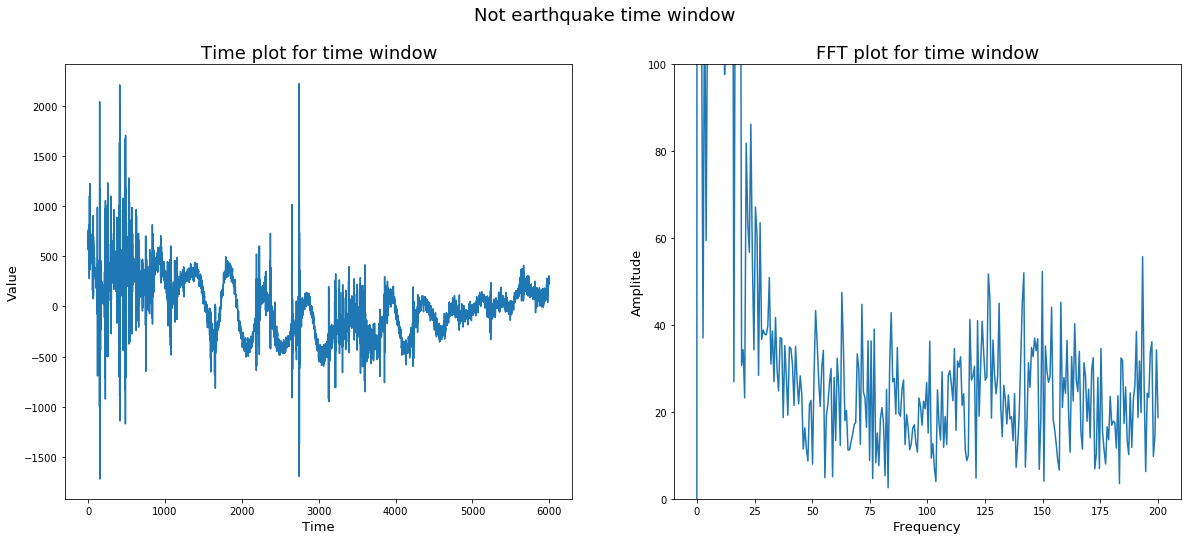

Median : 183.93313135228877 Mean: 186.58529398707915 Jules: 17562.433324352292


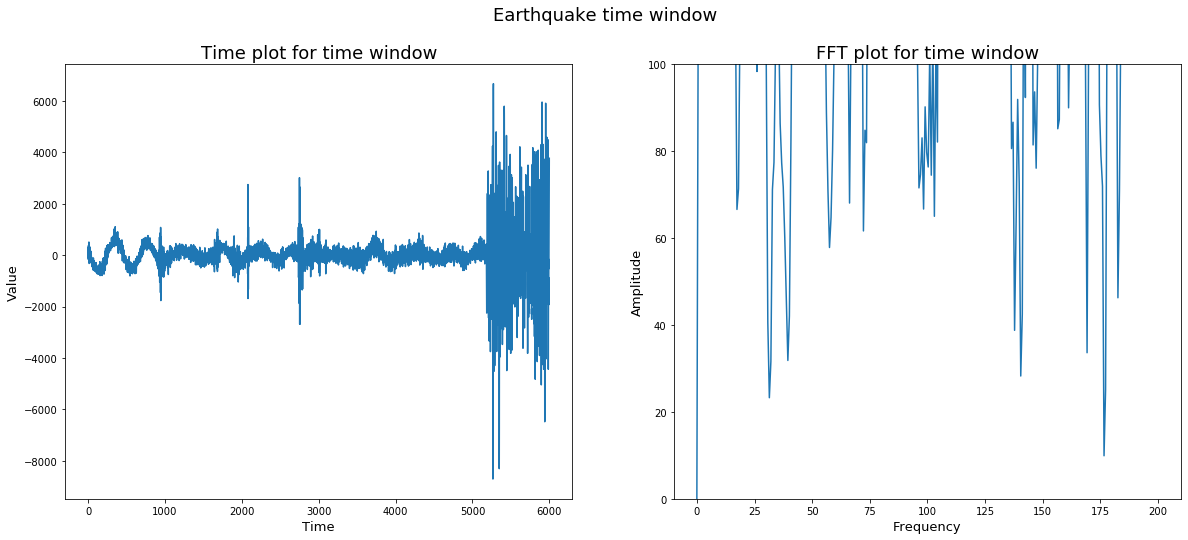

Median : 18.179667477266783 Mean: 19.44420875350986 Jules: 1529.3295410030587


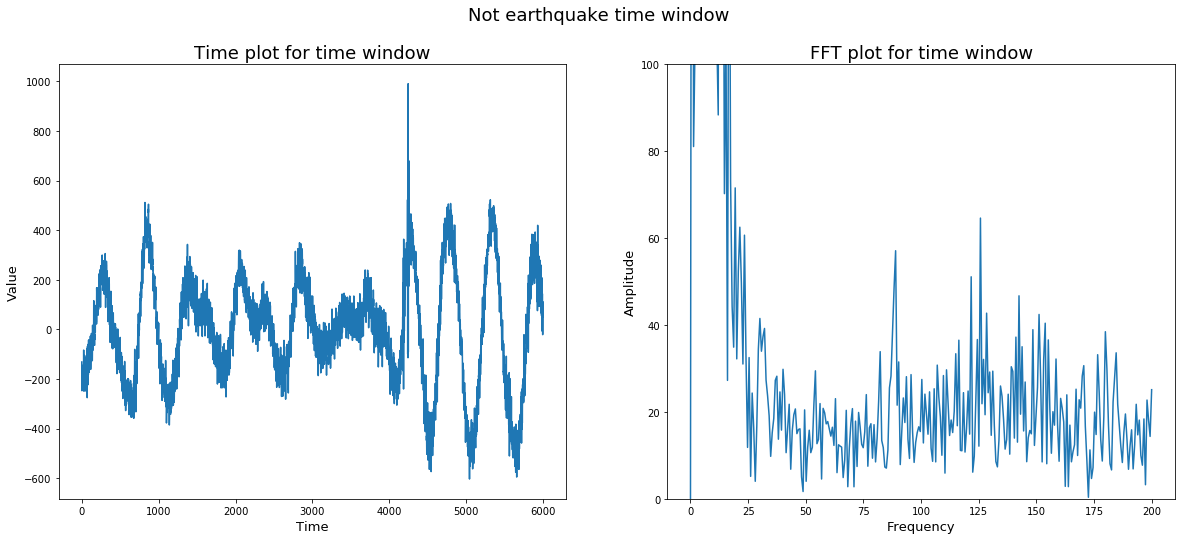

Median : 62.96825918873626 Mean: 62.485929051339944 Jules: 5613.139238539944


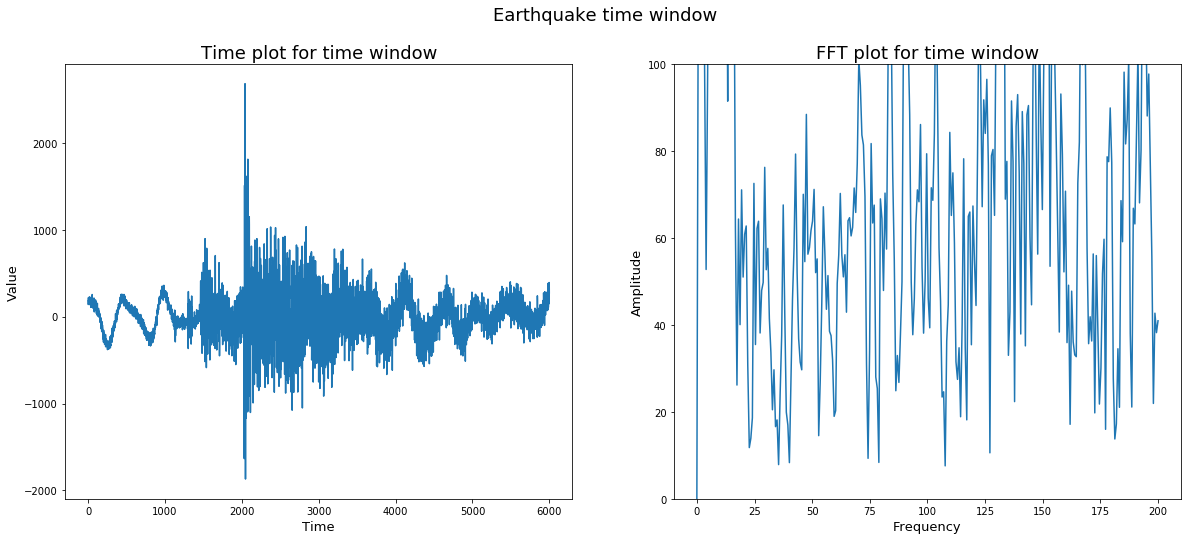

Median : 12.613478149101368 Mean: 12.97266215361557 Jules: 1117.7017109360077


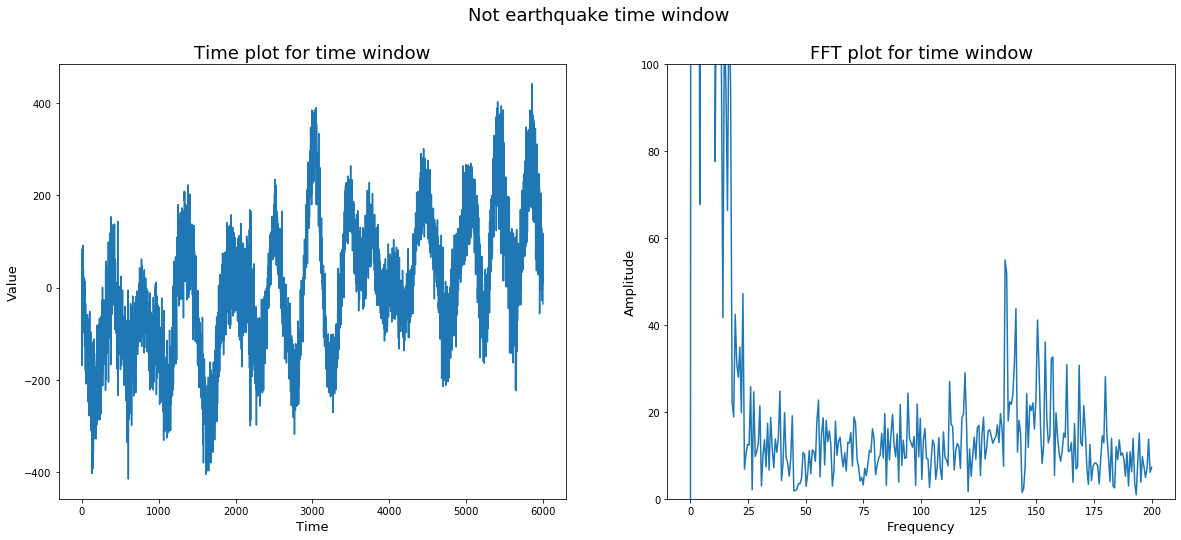

Median : 39.84989084174012 Mean: 41.76983439124567 Jules: 3757.4583699092273


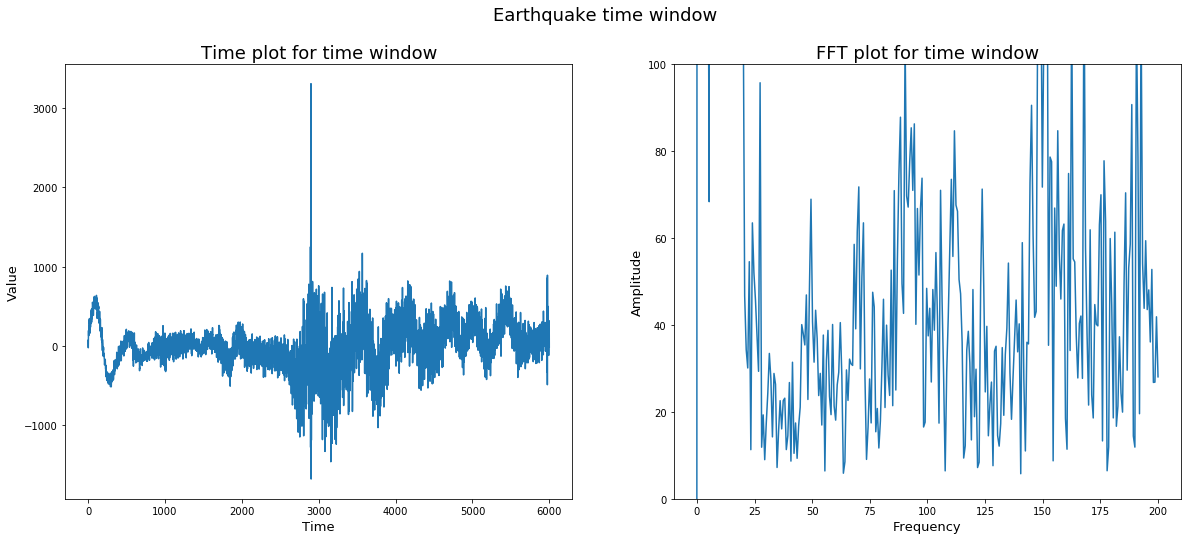

Median : 32.52556154949664 Mean: 34.26583333208305 Jules: 2641.697140224295


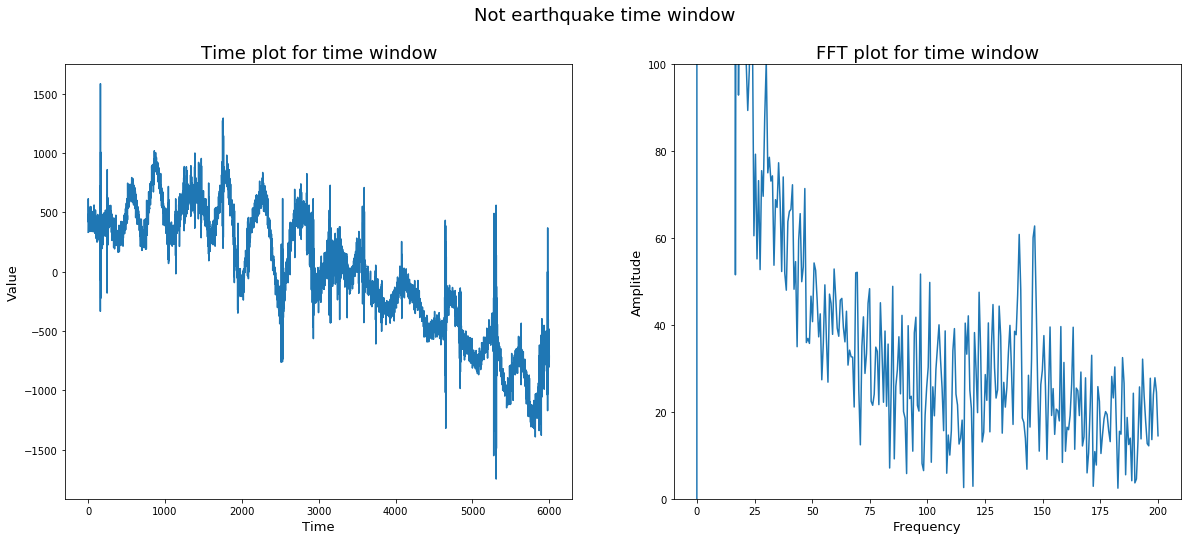

Median : 971.6000541449599 Mean: 1301.0808315134789 Jules: 110347.17675139429


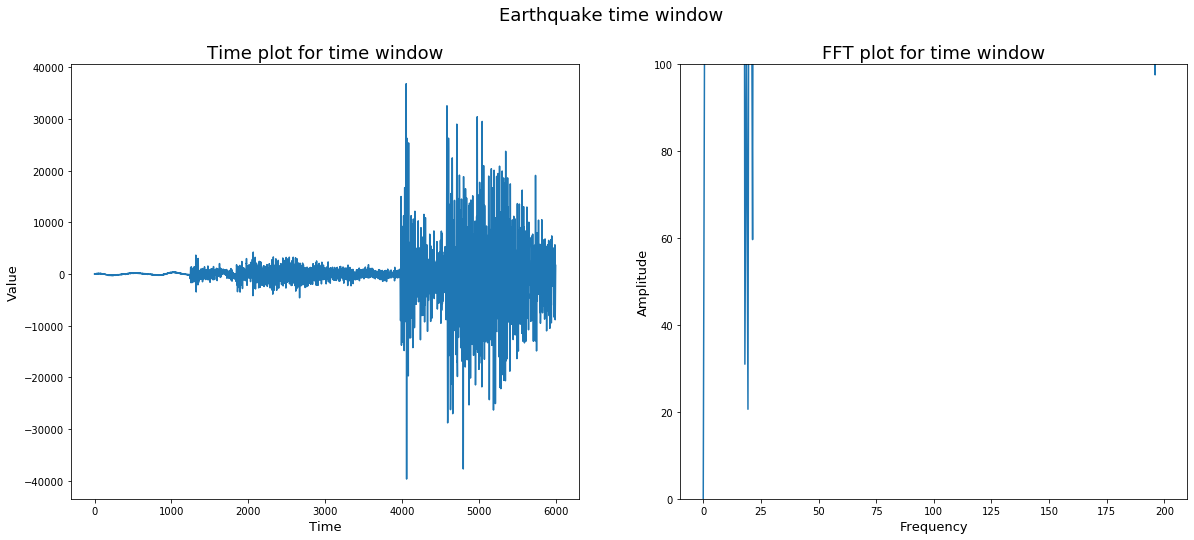

Median : 48.299134746011234 Mean: 53.38316218401113 Jules: 4430.842955927401


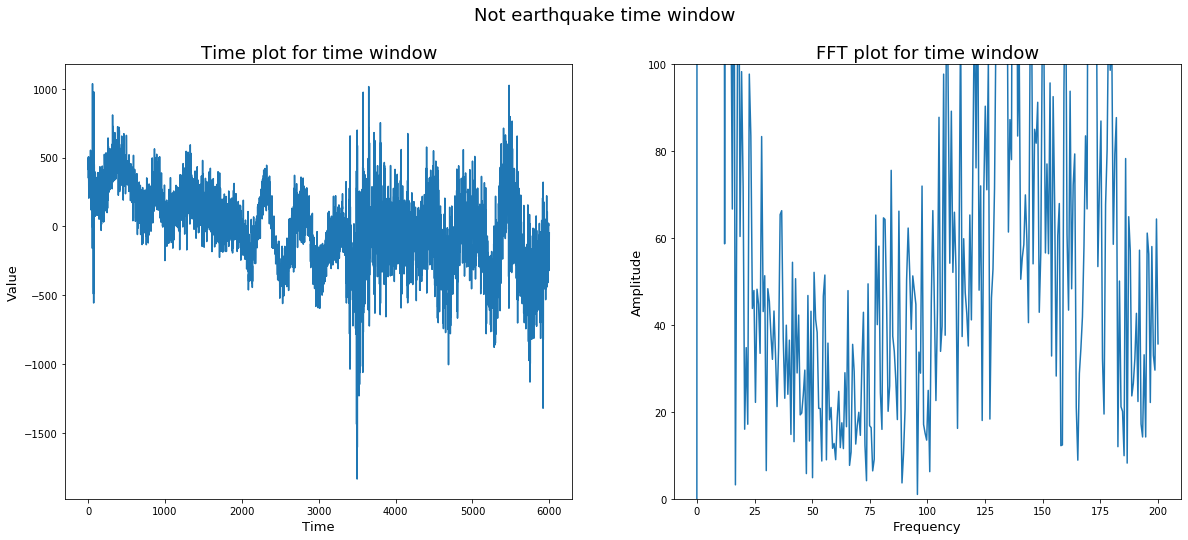

Median : 28.045551562436067 Mean: 27.05762917356522 Jules: 2518.1381895318646


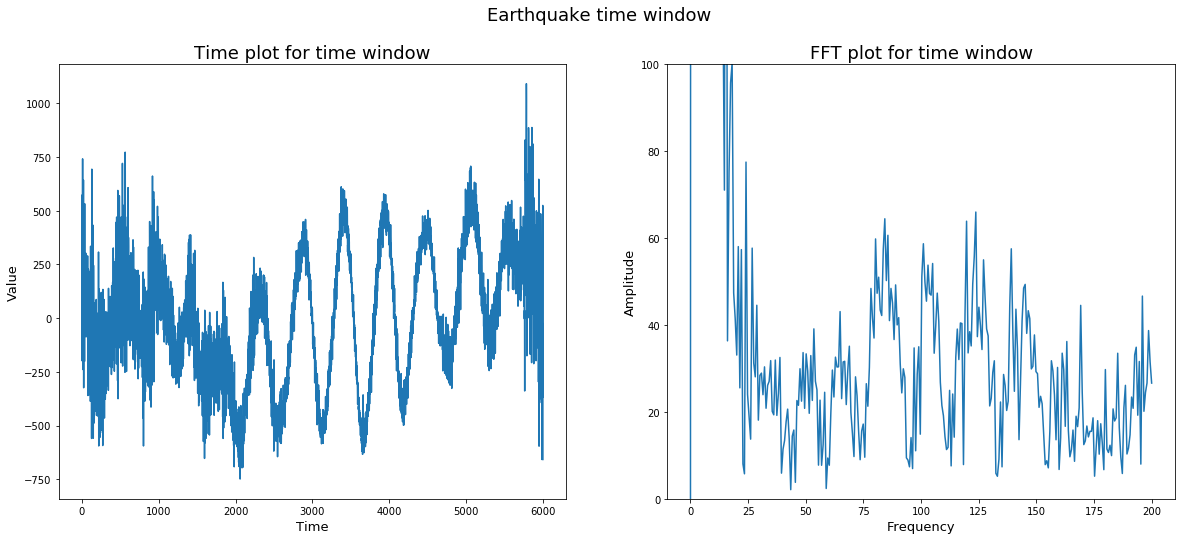

Median : 32.40207236545825 Mean: 33.12233311800167 Jules: 2483.0435428285814


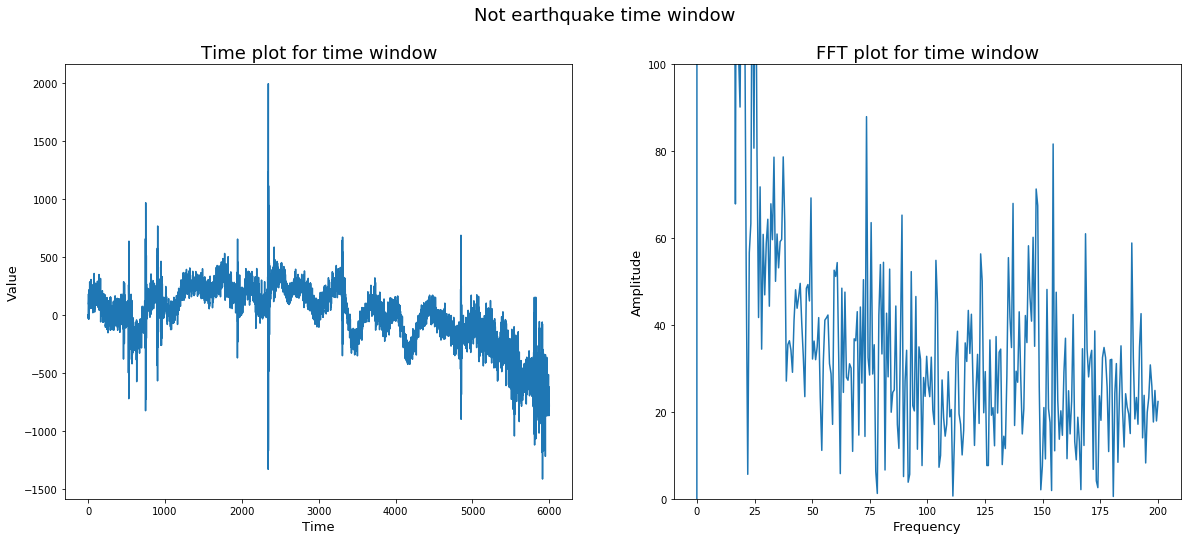

Median : 44.23323406569846 Mean: 46.88124509528061 Jules: 4306.245575128324


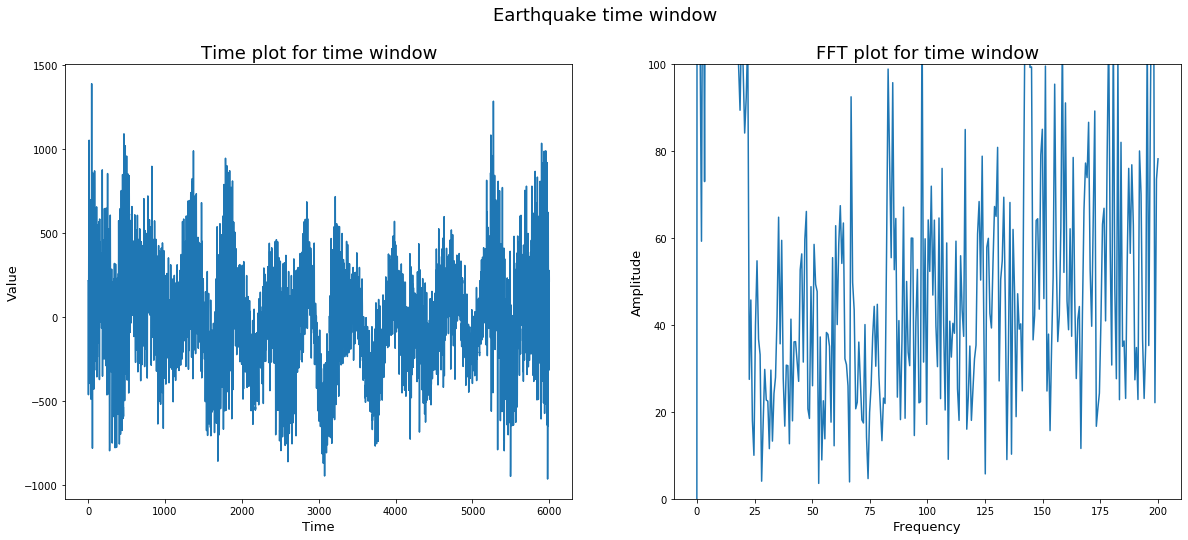

Median : 24.767294607033193 Mean: 28.47624720857669 Jules: 1870.200567581426


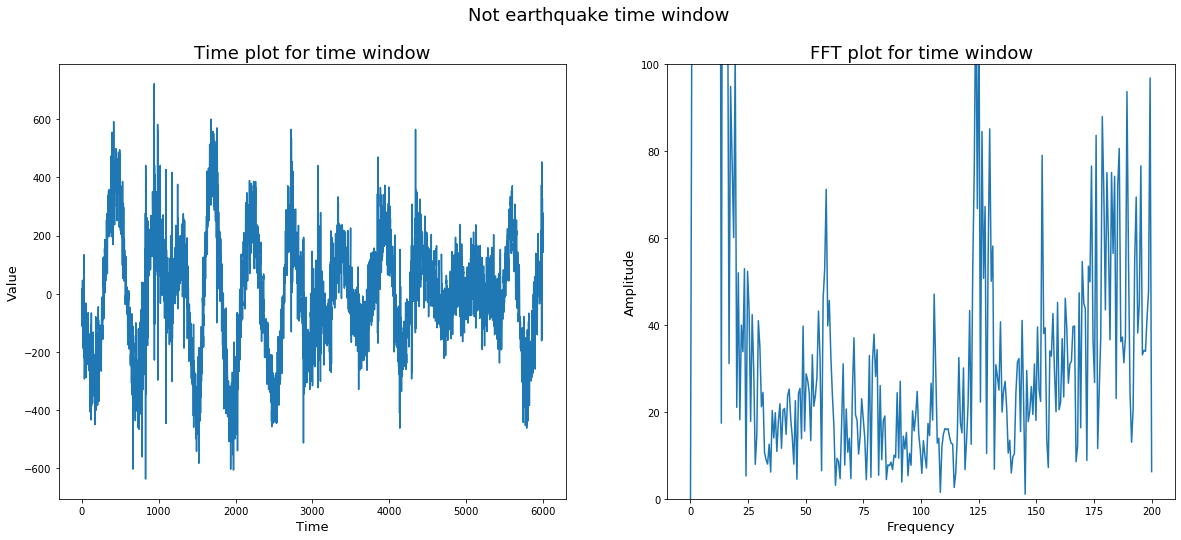

Median : 38.629920241385555 Mean: 40.44435216587564 Jules: 3085.680235719316


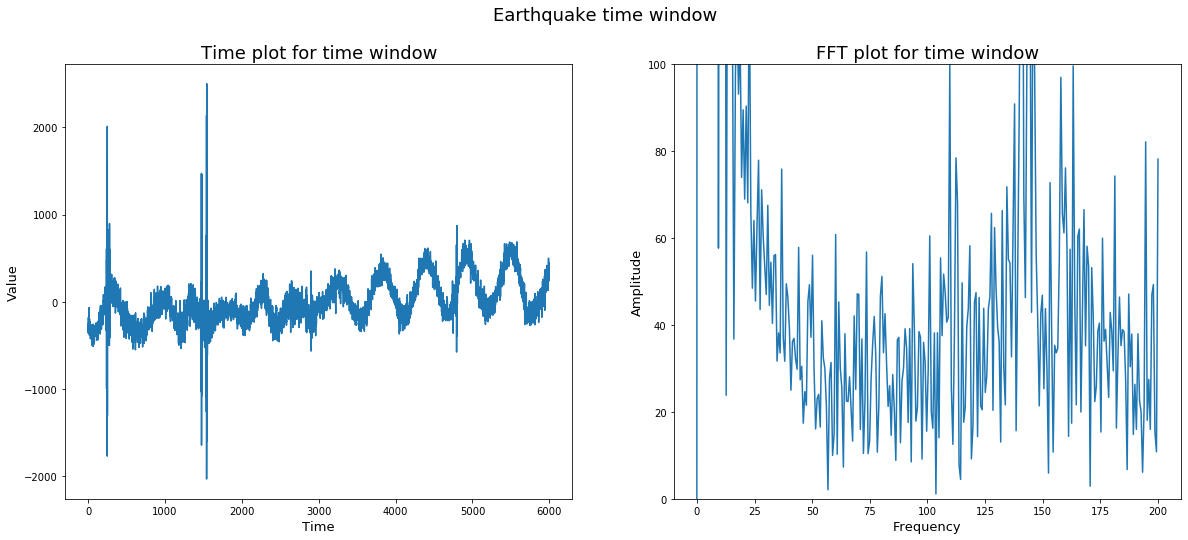

Median : 18.264721604353333 Mean: 19.307483321263526 Jules: 1394.7571316717526


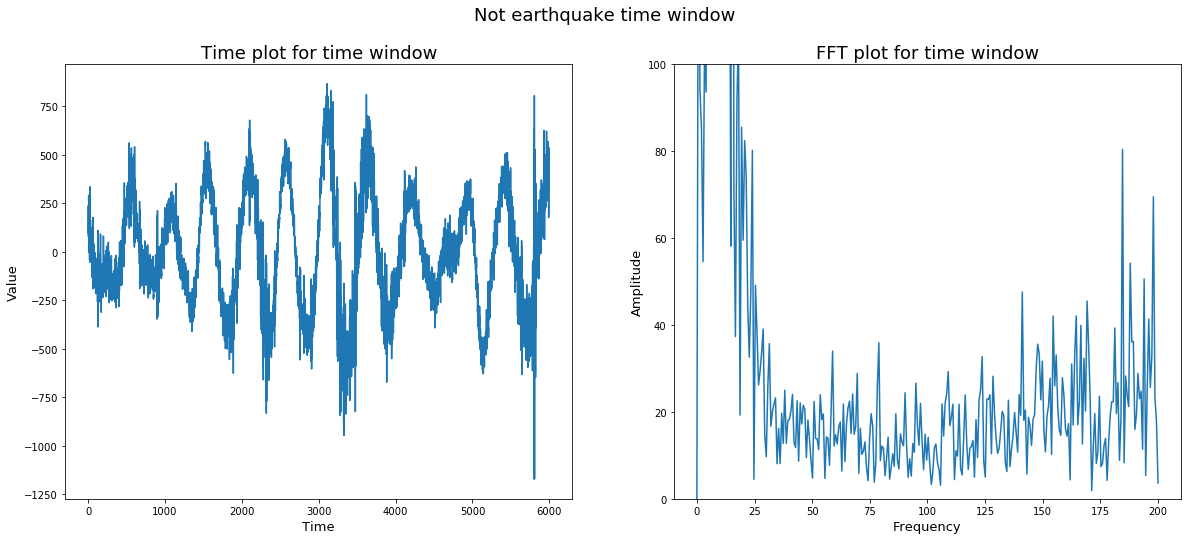

Median : 60.73489011623134 Mean: 61.93374472307871 Jules: 4948.212286788857


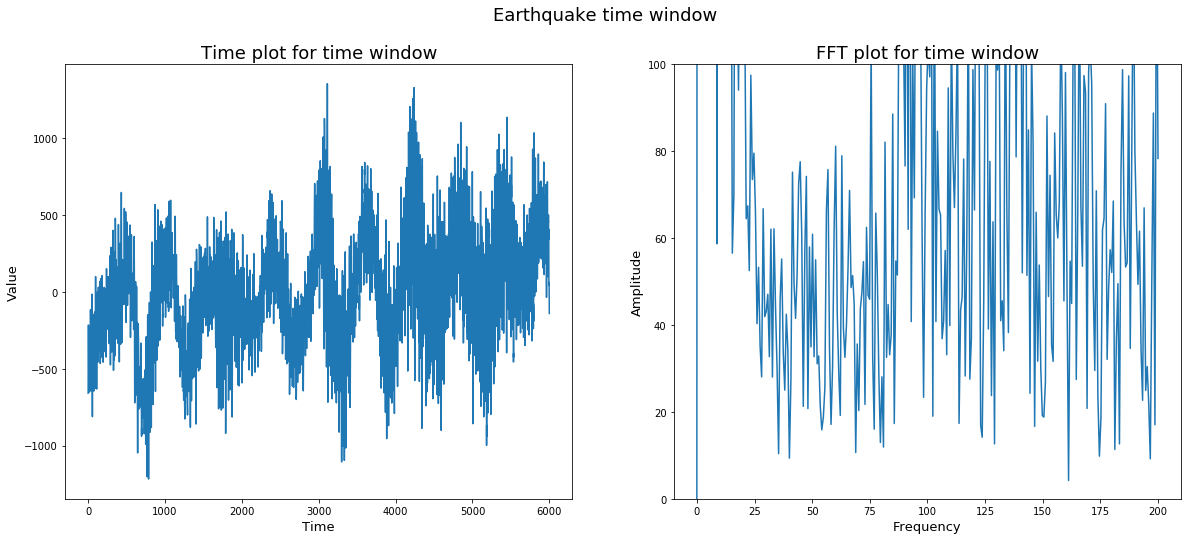

Median : 19.71718658571172 Mean: 20.430982559437204 Jules: 1685.3823171290514


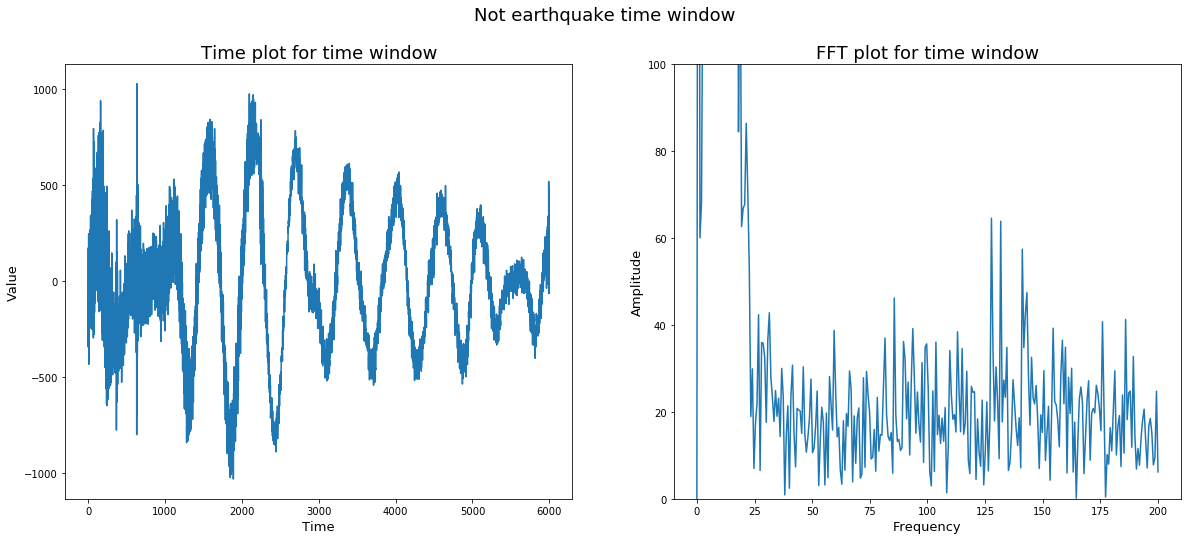

Median : 67.79972103510667 Mean: 77.65374065102631 Jules: 5932.857194798061


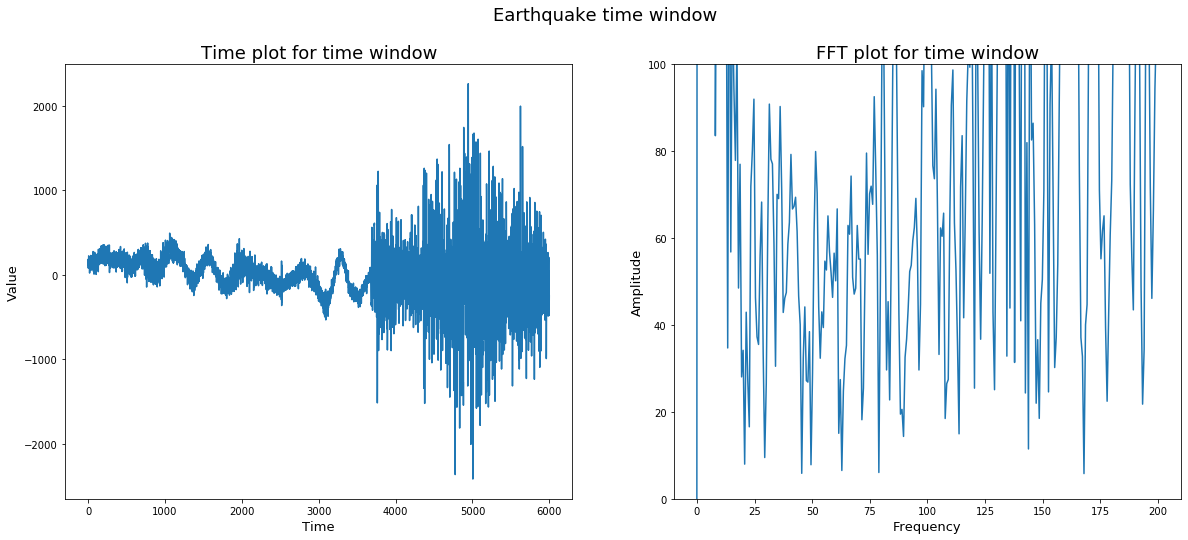

Median : 7.911909201639423 Mean: 9.490596609254805 Jules: 692.7247292793056


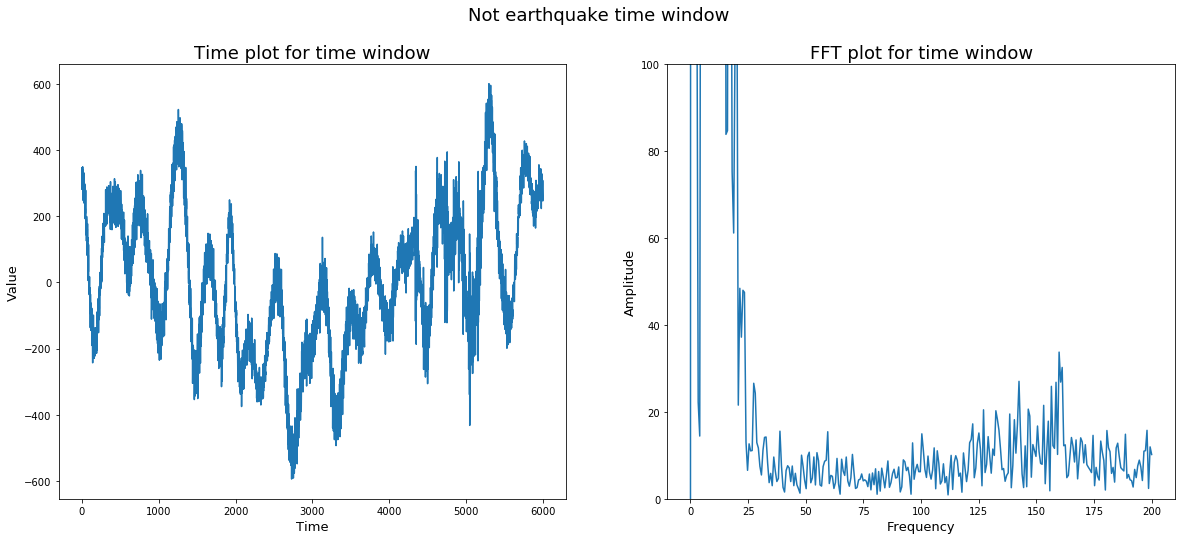

In [86]:
nm_plots = 25

eqs = np.random.choice(earthquake_time_stamps, nm_plots, replace=True)
not_eqs = np.random.choice(not_earthquake_time_stamps, nm_plots, replace=True)

stats = pd.DataFrame(columns=['median', 'mean', 'jules'])
for i, (eq, not_eq) in enumerate(list(zip(eqs, not_eqs))):
    if i > 25:
        break
    plot_window_timestamp(eq, True, stats, i)
    plot_window_timestamp(not_eq, False, stats, i+1000)
